In [1]:
import os
import json
import pandas as pd
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import timm
from utils import to_grayscale, resize_img, clean_ds, split_dataset
from model import StackedCNN2, StackedCNN, BasicCNN, SimpleModel
from train import training, test
from torch.nn import functional as F


In [2]:
IMG_PATH = 'data/Data/train_images'
LABEL_PATH = 'data/Data/label_num_to_disease_map.json'
IMAGE_LABEL_PATH = 'data/Data/train.csv'
DOWNSIZED_PATH = 'data/Data/downsized'
DOWNSIZED_GRAYSCALE_PATH = 'data/Data/downsized_grayscale'
GRAYSCALE_PATH = 'data/Data/grayscale'
TRAIN_CSV_PATH = 'data/Data/reindexed_train.csv'
img_list = os.listdir(IMG_PATH)

target_size = (256, 192)
#resize_img(IMG_PATH, img_list, DOWNSIZED_PATH,target_size)
#to_grayscale(IMG_PATH, img_list, GRAYSCALE_PATH)
#clean_ds(IMAGE_LABEL_PATH, IMG_PATH)


In [3]:
train_dataloader, val_dataloader, test_dataloader = split_dataset(DOWNSIZED_PATH,TRAIN_CSV_PATH, bs=64)

In [4]:
from collections import defaultdict
class_counts_train = defaultdict(int)
for batch in train_dataloader:
    for label in batch[1]:
        class_counts_train[label.item()] += 1
 class_counts_val = defaultdict(int)
for batch in val_dataloader:
    for label in batch[1]:
         class_counts_val[label.item()] += 1
 class_counts_test = defaultdict(int)
for batch in test_dataloader:
    for label in batch[1]:
         class_counts_test[label.item()] += 1
for i in range(5):
    print(f'Train class {i} count: {class_counts_train[i]}')
    print(f'Val class {i} count: {class_counts_val[i]}')
    print(f'Test class {i} count: {class_counts_test[i]}')
    print('---')

item_totals_train = 0
item_totals_test = 0
item_totals_val = 0

for i in range(5):
    item_totals_train += class_counts_train[i]
    item_totals_test += class_counts_test[i]
    # item_totals_val += class_counts_val[i]

for i in range(5):
    print(f'Train class {i} percentage: {(class_counts_train[i] / item_totals_train) * 100}')
    print(f'Val class {i} percentage: {(class_counts_val[i] / item_totals_val) * 100}')
    print(f'Test class {i} percentage: {(class_counts_test[i] / item_totals_test) * 100}')

Train class 0 percentage: 5.138450102211485
Train class 1 percentage: 10.211856532243077
Train class 2 percentage: 11.103884036424457
Train class 3 percentage: 61.46627020999814
Train class 4 percentage: 12.07953911912284


In [5]:
#Adding weights to mitigate class imbalance.
#weights used to skew the loss function in favor of the underrepresented class.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_items = len(train_dataloader)*train_dataloader.batch_size
weights = torch.tensor([num_items/class_counts_train[i] for i in range(5)]).to(device)

print(weights)

tensor([19.5588,  9.8417,  9.0510,  1.6351,  8.3200], device='cuda:0')


# Training Baseline Models


In [6]:
# model = SimpleModel(3*256*192, 512, 5)
# training(model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=20, model_name='SimpleModel', loss_weights=weights, lr=1e-5, wd = 1e-5, optimize=0)
# _ = test(model, test_dataloader, model_name='SimpleModel')
# torch.cuda.empty_cache()  # PyTorch


In [7]:
model = BasicCNN(input_dim=3, num_filter= 64, k_size=3, pool_size=2, dense_size=512,num_classes=5, stride=1, img_x=256, img_y=192)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=20, model_name=f'BasicCNN', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'BasicCNN')
torch.cuda.empty_cache()  # PyTorch



Training procedure:   5%|▌         | 1/20 [00:50<16:00, 50.55s/it]

Epoch 1/20:
Training Loss: 2.2643, Training Accuracy: 0.2460, train_f1: 0.1869
Validation Loss: 1.4622, Validation Accuracy: 0.4473, val_f1: 0.2023


Training procedure:  10%|█         | 2/20 [01:38<14:47, 49.30s/it]

Epoch 2/20:
Training Loss: 1.4725, Training Accuracy: 0.2625, train_f1: 0.2012
Validation Loss: 1.5742, Validation Accuracy: 0.1396, val_f1: 0.1411


Training procedure:  15%|█▌        | 3/20 [02:26<13:41, 48.34s/it]

Epoch 3/20:
Training Loss: 1.4119, Training Accuracy: 0.2567, train_f1: 0.2155
Validation Loss: 1.6528, Validation Accuracy: 0.2252, val_f1: 0.1821


Training procedure:  20%|██        | 4/20 [03:13<12:48, 48.01s/it]

Epoch 4/20:
Training Loss: 1.3664, Training Accuracy: 0.2976, train_f1: 0.2479
Validation Loss: 1.3653, Validation Accuracy: 0.4362, val_f1: 0.2704


Training procedure:  25%|██▌       | 5/20 [04:01<11:59, 47.97s/it]

Epoch 5/20:
Training Loss: 1.3133, Training Accuracy: 0.3073, train_f1: 0.2654
Validation Loss: 1.3504, Validation Accuracy: 0.3158, val_f1: 0.2330


Training procedure:  30%|███       | 6/20 [04:50<11:16, 48.32s/it]

Epoch 6/20:
Training Loss: 1.2684, Training Accuracy: 0.3487, train_f1: 0.3040
Validation Loss: 1.4389, Validation Accuracy: 0.3211, val_f1: 0.2536


Training procedure:  35%|███▌      | 7/20 [05:41<10:38, 49.09s/it]

Epoch 7/20:
Training Loss: 1.2259, Training Accuracy: 0.3807, train_f1: 0.3251
Validation Loss: 1.2968, Validation Accuracy: 0.2851, val_f1: 0.2538


Training procedure:  40%|████      | 8/20 [06:30<09:49, 49.10s/it]

Epoch 8/20:
Training Loss: 1.1850, Training Accuracy: 0.3993, train_f1: 0.3544
Validation Loss: 1.5385, Validation Accuracy: 0.2441, val_f1: 0.2424


Training procedure:  45%|████▌     | 9/20 [07:18<08:56, 48.78s/it]

Epoch 9/20:
Training Loss: 1.1426, Training Accuracy: 0.4222, train_f1: 0.3887
Validation Loss: 1.2908, Validation Accuracy: 0.4493, val_f1: 0.3102


Training procedure:  50%|█████     | 10/20 [08:06<08:04, 48.45s/it]

Epoch 10/20:
Training Loss: 1.0963, Training Accuracy: 0.4551, train_f1: 0.4176
Validation Loss: 1.2552, Validation Accuracy: 0.4300, val_f1: 0.3113


Training procedure:  55%|█████▌    | 11/20 [08:54<07:16, 48.53s/it]

Epoch 11/20:
Training Loss: 1.0641, Training Accuracy: 0.4807, train_f1: 0.4455
Validation Loss: 1.3463, Validation Accuracy: 0.3241, val_f1: 0.2989


Training procedure:  60%|██████    | 12/20 [09:42<06:26, 48.37s/it]

Epoch 12/20:
Training Loss: 1.0288, Training Accuracy: 0.4894, train_f1: 0.4619
Validation Loss: 1.2671, Validation Accuracy: 0.4824, val_f1: 0.3322


Training procedure:  65%|██████▌   | 13/20 [10:30<05:38, 48.29s/it]

Epoch 13/20:
Training Loss: 0.9868, Training Accuracy: 0.5304, train_f1: 0.5038
Validation Loss: 1.2620, Validation Accuracy: 0.4376, val_f1: 0.3378


Training procedure:  70%|███████   | 14/20 [11:19<04:49, 48.31s/it]

Epoch 14/20:
Training Loss: 0.9561, Training Accuracy: 0.5584, train_f1: 0.5254
Validation Loss: 1.2624, Validation Accuracy: 0.4638, val_f1: 0.3380


Training procedure:  75%|███████▌  | 15/20 [12:06<04:00, 48.10s/it]

Epoch 15/20:
Training Loss: 0.9333, Training Accuracy: 0.5753, train_f1: 0.5383
Validation Loss: 1.1981, Validation Accuracy: 0.5092, val_f1: 0.3474


Training procedure:  80%|████████  | 16/20 [12:55<03:12, 48.23s/it]

Epoch 16/20:
Training Loss: 0.8893, Training Accuracy: 0.5952, train_f1: 0.5582
Validation Loss: 1.2471, Validation Accuracy: 0.4139, val_f1: 0.3224


Training procedure:  85%|████████▌ | 17/20 [13:44<02:25, 48.42s/it]

Epoch 17/20:
Training Loss: 0.8535, Training Accuracy: 0.6081, train_f1: 0.5791
Validation Loss: 1.3029, Validation Accuracy: 0.3487, val_f1: 0.3041


Training procedure:  90%|█████████ | 18/20 [14:35<01:38, 49.13s/it]

Epoch 18/20:
Training Loss: 0.8180, Training Accuracy: 0.6307, train_f1: 0.6016
Validation Loss: 1.2259, Validation Accuracy: 0.4395, val_f1: 0.3318


Training procedure:  95%|█████████▌| 19/20 [15:25<00:49, 49.43s/it]

Epoch 19/20:
Training Loss: 0.8012, Training Accuracy: 0.6320, train_f1: 0.5951
Validation Loss: 1.2034, Validation Accuracy: 0.4939, val_f1: 0.3451


Training procedure: 100%|██████████| 20/20 [16:14<00:00, 48.72s/it]

Epoch 20/20:
Training Loss: 0.7659, Training Accuracy: 0.6669, train_f1: 0.6248
Validation Loss: 1.2825, Validation Accuracy: 0.4186, val_f1: 0.3234


Test Accuracy: 0.4273
Test F1: 0.3384
Test Precision: 0.35824849223998484
Test Recall: 0.37256228283014037


In [12]:
model = StackedCNN2(input_dim=3, num_filter= 64, k_size=3, pool_size=2, dense_size=512,num_classes=5, stride=1, img_x=256, img_y=192)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=20, model_name=f'StackedCNN2', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'StackedCNN2')
torch.cuda.empty_cache()  # PyTorch


Training procedure:   0%|          | 0/20 [00:53<?, ?it/s]


KeyboardInterrupt: 

# SoTA Architectures - No Pretrain

In [18]:
model = timm.create_model('resnet50', num_classes = 5, pretrained=False)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=20, model_name=f'resnet50_np', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'resnet50_np')
torch.cuda.empty_cache()  # PyTorch


Training procedure:   5%|▌         | 1/20 [00:43<13:50, 43.72s/it]

Epoch 1/20:
Training Loss: 1.5488, Training Accuracy: 0.2612, train_f1: 0.2166
Validation Loss: 1.4585, Validation Accuracy: 0.4114, val_f1: 0.3021


Training procedure:  10%|█         | 2/20 [01:27<13:05, 43.65s/it]

Epoch 2/20:
Training Loss: 1.4701, Training Accuracy: 0.4310, train_f1: 0.3140
Validation Loss: 1.3746, Validation Accuracy: 0.4724, val_f1: 0.3380


Training procedure:  15%|█▌        | 3/20 [02:12<12:34, 44.36s/it]

Epoch 3/20:
Training Loss: 1.4348, Training Accuracy: 0.4699, train_f1: 0.3399
Validation Loss: 1.3883, Validation Accuracy: 0.4629, val_f1: 0.3392


Training procedure:  20%|██        | 4/20 [02:55<11:41, 43.86s/it]

Epoch 4/20:
Training Loss: 1.4092, Training Accuracy: 0.4839, train_f1: 0.3571
Validation Loss: 1.3352, Validation Accuracy: 0.4989, val_f1: 0.3595


Training procedure:  25%|██▌       | 5/20 [03:38<10:52, 43.49s/it]

Epoch 5/20:
Training Loss: 1.3863, Training Accuracy: 0.5070, train_f1: 0.3753
Validation Loss: 1.3233, Validation Accuracy: 0.4872, val_f1: 0.3584


Training procedure:  30%|███       | 6/20 [04:22<10:09, 43.52s/it]

Epoch 6/20:
Training Loss: 1.3717, Training Accuracy: 0.5113, train_f1: 0.3788
Validation Loss: 1.2725, Validation Accuracy: 0.5181, val_f1: 0.3615


Training procedure:  35%|███▌      | 7/20 [05:05<09:26, 43.58s/it]

Epoch 7/20:
Training Loss: 1.3543, Training Accuracy: 0.5054, train_f1: 0.3836
Validation Loss: 1.2770, Validation Accuracy: 0.5078, val_f1: 0.3741


Training procedure:  40%|████      | 8/20 [05:49<08:42, 43.52s/it]

Epoch 8/20:
Training Loss: 1.3433, Training Accuracy: 0.5186, train_f1: 0.3922
Validation Loss: 1.3153, Validation Accuracy: 0.5017, val_f1: 0.3734


Training procedure:  45%|████▌     | 9/20 [06:33<08:00, 43.67s/it]

Epoch 9/20:
Training Loss: 1.3261, Training Accuracy: 0.5284, train_f1: 0.4061
Validation Loss: 1.2590, Validation Accuracy: 0.5220, val_f1: 0.3748


Training procedure:  50%|█████     | 10/20 [07:15<07:13, 43.31s/it]

Epoch 10/20:
Training Loss: 1.3121, Training Accuracy: 0.5403, train_f1: 0.4082
Validation Loss: 1.2712, Validation Accuracy: 0.5075, val_f1: 0.3824


Training procedure:  55%|█████▌    | 11/20 [07:58<06:29, 43.27s/it]

Epoch 11/20:
Training Loss: 1.2950, Training Accuracy: 0.5350, train_f1: 0.4204
Validation Loss: 1.2242, Validation Accuracy: 0.5585, val_f1: 0.4052


Training procedure:  60%|██████    | 12/20 [08:40<05:43, 42.92s/it]

Epoch 12/20:
Training Loss: 1.2787, Training Accuracy: 0.5499, train_f1: 0.4251
Validation Loss: 1.1638, Validation Accuracy: 0.5630, val_f1: 0.4024


Training procedure:  65%|██████▌   | 13/20 [09:24<05:02, 43.15s/it]

Epoch 13/20:
Training Loss: 1.2653, Training Accuracy: 0.5463, train_f1: 0.4306
Validation Loss: 1.1878, Validation Accuracy: 0.5507, val_f1: 0.4001


Training procedure:  70%|███████   | 14/20 [10:08<04:19, 43.32s/it]

Epoch 14/20:
Training Loss: 1.2472, Training Accuracy: 0.5612, train_f1: 0.4428
Validation Loss: 1.1906, Validation Accuracy: 0.5474, val_f1: 0.4022


Training procedure:  75%|███████▌  | 15/20 [10:52<03:37, 43.44s/it]

Epoch 15/20:
Training Loss: 1.2346, Training Accuracy: 0.5495, train_f1: 0.4421
Validation Loss: 1.2076, Validation Accuracy: 0.5407, val_f1: 0.4050


Training procedure:  80%|████████  | 16/20 [11:34<02:52, 43.12s/it]

Epoch 16/20:
Training Loss: 1.2193, Training Accuracy: 0.5616, train_f1: 0.4533
Validation Loss: 1.1876, Validation Accuracy: 0.5151, val_f1: 0.4036


Training procedure:  85%|████████▌ | 17/20 [12:18<02:10, 43.37s/it]

Epoch 17/20:
Training Loss: 1.1935, Training Accuracy: 0.5735, train_f1: 0.4666
Validation Loss: 1.1449, Validation Accuracy: 0.5488, val_f1: 0.4193


Training procedure:  90%|█████████ | 18/20 [13:00<01:26, 43.13s/it]

Epoch 18/20:
Training Loss: 1.1739, Training Accuracy: 0.5720, train_f1: 0.4691
Validation Loss: 1.2103, Validation Accuracy: 0.5167, val_f1: 0.4091


Training procedure:  95%|█████████▌| 19/20 [13:44<00:43, 43.27s/it]

Epoch 19/20:
Training Loss: 1.1585, Training Accuracy: 0.5768, train_f1: 0.4758
Validation Loss: 1.1424, Validation Accuracy: 0.5569, val_f1: 0.4222


Training procedure: 100%|██████████| 20/20 [14:27<00:00, 43.40s/it]

Epoch 20/20:
Training Loss: 1.1304, Training Accuracy: 0.5897, train_f1: 0.4903
Validation Loss: 1.1424, Validation Accuracy: 0.5206, val_f1: 0.4102


Test Accuracy: 0.5187
Test F1: 0.4109
Test Precision: 0.41943492486735956
Test Recall: 0.4439987698045976


In [19]:
model = timm.create_model('rexnet_150', num_classes = 5, pretrained=False)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=20, model_name=f'rexnet_150_np', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'rexnet_150_np')
torch.cuda.empty_cache()  # PyTorch


Training procedure:   5%|▌         | 1/20 [00:43<13:46, 43.50s/it]

Epoch 1/20:
Training Loss: 3.5550, Training Accuracy: 0.0923, train_f1: 0.0918
Validation Loss: 3.8343, Validation Accuracy: 0.0878, val_f1: 0.0950


Training procedure:  10%|█         | 2/20 [01:26<12:57, 43.18s/it]

Epoch 2/20:
Training Loss: 2.7848, Training Accuracy: 0.1409, train_f1: 0.1410
Validation Loss: 3.0551, Validation Accuracy: 0.1171, val_f1: 0.1241


Training procedure:  15%|█▌        | 3/20 [02:09<12:13, 43.14s/it]

Epoch 3/20:
Training Loss: 2.3057, Training Accuracy: 0.1882, train_f1: 0.1813
Validation Loss: 2.2970, Validation Accuracy: 0.1853, val_f1: 0.1716


Training procedure:  20%|██        | 4/20 [02:52<11:28, 43.06s/it]

Epoch 4/20:
Training Loss: 2.0392, Training Accuracy: 0.2500, train_f1: 0.2242
Validation Loss: 1.8933, Validation Accuracy: 0.2533, val_f1: 0.2006


Training procedure:  25%|██▌       | 5/20 [03:36<10:49, 43.28s/it]

Epoch 5/20:
Training Loss: 1.8165, Training Accuracy: 0.3022, train_f1: 0.2655
Validation Loss: 1.7855, Validation Accuracy: 0.2860, val_f1: 0.2198


Training procedure:  30%|███       | 6/20 [04:18<10:03, 43.08s/it]

Epoch 6/20:
Training Loss: 1.7424, Training Accuracy: 0.3352, train_f1: 0.2924
Validation Loss: 1.7627, Validation Accuracy: 0.2996, val_f1: 0.2261


Training procedure:  35%|███▌      | 7/20 [05:02<09:22, 43.26s/it]

Epoch 7/20:
Training Loss: 1.5817, Training Accuracy: 0.3728, train_f1: 0.3281
Validation Loss: 1.7447, Validation Accuracy: 0.3200, val_f1: 0.2363


Training procedure:  40%|████      | 8/20 [05:46<08:41, 43.43s/it]

Epoch 8/20:
Training Loss: 1.5013, Training Accuracy: 0.3959, train_f1: 0.3512
Validation Loss: 1.7598, Validation Accuracy: 0.3297, val_f1: 0.2381


Training procedure:  45%|████▌     | 9/20 [06:30<08:02, 43.83s/it]

Epoch 9/20:
Training Loss: 1.4051, Training Accuracy: 0.4145, train_f1: 0.3696
Validation Loss: 1.6967, Validation Accuracy: 0.3520, val_f1: 0.2451


Training procedure:  50%|█████     | 10/20 [07:16<07:24, 44.43s/it]

Epoch 10/20:
Training Loss: 1.3221, Training Accuracy: 0.4283, train_f1: 0.3889
Validation Loss: 1.7596, Validation Accuracy: 0.3489, val_f1: 0.2522


Training procedure:  55%|█████▌    | 11/20 [08:01<06:41, 44.58s/it]

Epoch 11/20:
Training Loss: 1.1873, Training Accuracy: 0.4642, train_f1: 0.4322
Validation Loss: 1.7729, Validation Accuracy: 0.3609, val_f1: 0.2498


Training procedure:  60%|██████    | 12/20 [08:50<06:07, 45.88s/it]

Epoch 12/20:
Training Loss: 1.1216, Training Accuracy: 0.4866, train_f1: 0.4561
Validation Loss: 1.7428, Validation Accuracy: 0.3595, val_f1: 0.2506


Training procedure:  65%|██████▌   | 13/20 [09:34<05:16, 45.17s/it]

Epoch 13/20:
Training Loss: 1.0195, Training Accuracy: 0.5233, train_f1: 0.4945
Validation Loss: 1.7314, Validation Accuracy: 0.3506, val_f1: 0.2504


Training procedure:  70%|███████   | 14/20 [10:17<04:27, 44.51s/it]

Epoch 14/20:
Training Loss: 0.9538, Training Accuracy: 0.5443, train_f1: 0.5136
Validation Loss: 1.7843, Validation Accuracy: 0.3676, val_f1: 0.2489


Training procedure:  75%|███████▌  | 15/20 [11:00<03:41, 44.20s/it]

Epoch 15/20:
Training Loss: 0.8597, Training Accuracy: 0.5799, train_f1: 0.5551
Validation Loss: 1.7673, Validation Accuracy: 0.3986, val_f1: 0.2666


Training procedure:  80%|████████  | 16/20 [11:45<02:57, 44.42s/it]

Epoch 16/20:
Training Loss: 0.7861, Training Accuracy: 0.6114, train_f1: 0.5925
Validation Loss: 1.8185, Validation Accuracy: 0.3629, val_f1: 0.2503


Training procedure:  85%|████████▌ | 17/20 [12:28<02:11, 43.96s/it]

Epoch 17/20:
Training Loss: 0.6856, Training Accuracy: 0.6368, train_f1: 0.6198
Validation Loss: 1.8695, Validation Accuracy: 0.3955, val_f1: 0.2560


Training procedure:  90%|█████████ | 18/20 [13:13<01:28, 44.40s/it]

Epoch 18/20:
Training Loss: 0.6414, Training Accuracy: 0.6542, train_f1: 0.6386
Validation Loss: 1.8185, Validation Accuracy: 0.4222, val_f1: 0.2662


Training procedure:  95%|█████████▌| 19/20 [14:00<00:44, 44.99s/it]

Epoch 19/20:
Training Loss: 0.5611, Training Accuracy: 0.6865, train_f1: 0.6758
Validation Loss: 1.9114, Validation Accuracy: 0.4125, val_f1: 0.2593


Training procedure: 100%|██████████| 20/20 [14:44<00:00, 44.23s/it]

Epoch 20/20:
Training Loss: 0.5258, Training Accuracy: 0.7056, train_f1: 0.6943
Validation Loss: 1.9527, Validation Accuracy: 0.4200, val_f1: 0.2630


Test Accuracy: 0.4359
Test F1: 0.2863
Test Precision: 0.28556328489290217
Test Recall: 0.30489515643897347


# SoTA Architectures - Pretrained

In [20]:
model = timm.create_model('resnet50', num_classes = 5, pretrained=True)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=15, model_name=f'resnet50_pt', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'resnet50_pt')
torch.cuda.empty_cache()  # PyTorch


Training procedure:   7%|▋         | 1/15 [00:42<09:56, 42.63s/it]

Epoch 1/15:
Training Loss: 1.6075, Training Accuracy: 0.0817, train_f1: 0.0979
Validation Loss: 1.6267, Validation Accuracy: 0.1115, val_f1: 0.1284


Training procedure:  13%|█▎        | 2/15 [01:25<09:12, 42.53s/it]

Epoch 2/15:
Training Loss: 1.5882, Training Accuracy: 0.2240, train_f1: 0.2083
Validation Loss: 1.5824, Validation Accuracy: 0.3342, val_f1: 0.2588


Training procedure:  20%|██        | 3/15 [02:08<08:34, 42.88s/it]

Epoch 3/15:
Training Loss: 1.5688, Training Accuracy: 0.4497, train_f1: 0.3386
Validation Loss: 1.5483, Validation Accuracy: 0.5061, val_f1: 0.3457


Training procedure:  27%|██▋       | 4/15 [02:51<07:51, 42.89s/it]

Epoch 4/15:
Training Loss: 1.5458, Training Accuracy: 0.5475, train_f1: 0.4104
Validation Loss: 1.5170, Validation Accuracy: 0.5605, val_f1: 0.3750


Training procedure:  33%|███▎      | 5/15 [03:35<07:13, 43.32s/it]

Epoch 5/15:
Training Loss: 1.5185, Training Accuracy: 0.6142, train_f1: 0.4535
Validation Loss: 1.4814, Validation Accuracy: 0.5939, val_f1: 0.4054


Training procedure:  40%|████      | 6/15 [04:18<06:28, 43.18s/it]

Epoch 6/15:
Training Loss: 1.4800, Training Accuracy: 0.6435, train_f1: 0.4923
Validation Loss: 1.4481, Validation Accuracy: 0.5998, val_f1: 0.4210


Training procedure:  47%|████▋     | 7/15 [05:00<05:44, 43.02s/it]

Epoch 7/15:
Training Loss: 1.4327, Training Accuracy: 0.6555, train_f1: 0.5037
Validation Loss: 1.3882, Validation Accuracy: 0.6285, val_f1: 0.4384


Training procedure:  53%|█████▎    | 8/15 [05:44<05:02, 43.21s/it]

Epoch 8/15:
Training Loss: 1.3740, Training Accuracy: 0.6697, train_f1: 0.5166
Validation Loss: 1.3306, Validation Accuracy: 0.6444, val_f1: 0.4591


Training procedure:  60%|██████    | 9/15 [06:28<04:19, 43.27s/it]

Epoch 9/15:
Training Loss: 1.3080, Training Accuracy: 0.6870, train_f1: 0.5347
Validation Loss: 1.2655, Validation Accuracy: 0.6614, val_f1: 0.4740


Training procedure:  67%|██████▋   | 10/15 [07:10<03:35, 43.15s/it]

Epoch 10/15:
Training Loss: 1.2447, Training Accuracy: 0.6982, train_f1: 0.5541
Validation Loss: 1.2258, Validation Accuracy: 0.6583, val_f1: 0.4873


Training procedure:  73%|███████▎  | 11/15 [07:54<02:52, 43.23s/it]

Epoch 11/15:
Training Loss: 1.1852, Training Accuracy: 0.7108, train_f1: 0.5742
Validation Loss: 1.1646, Validation Accuracy: 0.6720, val_f1: 0.5006


Training procedure:  80%|████████  | 12/15 [08:37<02:09, 43.32s/it]

Epoch 12/15:
Training Loss: 1.1229, Training Accuracy: 0.7170, train_f1: 0.5885
Validation Loss: 1.1044, Validation Accuracy: 0.6848, val_f1: 0.5176


Training procedure:  87%|████████▋ | 13/15 [09:21<01:26, 43.31s/it]

Epoch 13/15:
Training Loss: 1.0705, Training Accuracy: 0.7230, train_f1: 0.6017
Validation Loss: 1.0524, Validation Accuracy: 0.7015, val_f1: 0.5392


Training procedure:  93%|█████████▎| 14/15 [10:04<00:43, 43.34s/it]

Epoch 14/15:
Training Loss: 1.0145, Training Accuracy: 0.7303, train_f1: 0.6207
Validation Loss: 1.0572, Validation Accuracy: 0.6870, val_f1: 0.5444


Training procedure: 100%|██████████| 15/15 [10:47<00:00, 43.18s/it]

Epoch 15/15:
Training Loss: 0.9715, Training Accuracy: 0.7344, train_f1: 0.6296
Validation Loss: 1.0189, Validation Accuracy: 0.6937, val_f1: 0.5502


Test Accuracy: 0.6848
Test F1: 0.5377
Test Precision: 0.5191178608126455
Test Recall: 0.5689174880266705


In [21]:
model = timm.create_model('rexnet_150', num_classes = 5, pretrained=True)
training(lr=1e-5, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=15, model_name=f'rexnet_150_pt', loss_weights=weights, wd = 1e-5, optimize=0)
_ = test(model, test_dataloader, model_name=f'rexnet_150_pt')
torch.cuda.empty_cache()  # PyTorch



Training procedure:   7%|▋         | 1/15 [00:42<09:55, 42.51s/it]

Epoch 1/15:
Training Loss: 2.9849, Training Accuracy: 0.2129, train_f1: 0.1931
Validation Loss: 2.3139, Validation Accuracy: 0.3074, val_f1: 0.2584


Training procedure:  13%|█▎        | 2/15 [01:25<09:15, 42.69s/it]

Epoch 2/15:
Training Loss: 2.0627, Training Accuracy: 0.3750, train_f1: 0.3133
Validation Loss: 1.7085, Validation Accuracy: 0.4334, val_f1: 0.3361


Training procedure:  20%|██        | 3/15 [02:08<08:34, 42.84s/it]

Epoch 3/15:
Training Loss: 1.6528, Training Accuracy: 0.4823, train_f1: 0.3936
Validation Loss: 1.4651, Validation Accuracy: 0.5072, val_f1: 0.3934


Training procedure:  27%|██▋       | 4/15 [02:51<07:51, 42.90s/it]

Epoch 4/15:
Training Loss: 1.3554, Training Accuracy: 0.5583, train_f1: 0.4703
Validation Loss: 1.3775, Validation Accuracy: 0.5332, val_f1: 0.4153


Training procedure:  33%|███▎      | 5/15 [03:34<07:11, 43.11s/it]

Epoch 5/15:
Training Loss: 1.1455, Training Accuracy: 0.6056, train_f1: 0.5143
Validation Loss: 1.2516, Validation Accuracy: 0.5755, val_f1: 0.4515


Training procedure:  40%|████      | 6/15 [04:17<06:25, 42.87s/it]

Epoch 6/15:
Training Loss: 0.9748, Training Accuracy: 0.6518, train_f1: 0.5686
Validation Loss: 1.0986, Validation Accuracy: 0.6159, val_f1: 0.4779


Training procedure:  47%|████▋     | 7/15 [05:00<05:43, 42.89s/it]

Epoch 7/15:
Training Loss: 0.8385, Training Accuracy: 0.6936, train_f1: 0.6206
Validation Loss: 1.0489, Validation Accuracy: 0.6341, val_f1: 0.4983


Training procedure:  53%|█████▎    | 8/15 [05:42<04:59, 42.76s/it]

Epoch 8/15:
Training Loss: 0.7123, Training Accuracy: 0.7256, train_f1: 0.6615
Validation Loss: 1.0371, Validation Accuracy: 0.6424, val_f1: 0.5067


Training procedure:  60%|██████    | 9/15 [06:25<04:15, 42.64s/it]

Epoch 9/15:
Training Loss: 0.6268, Training Accuracy: 0.7574, train_f1: 0.6966
Validation Loss: 0.9994, Validation Accuracy: 0.6591, val_f1: 0.5134


Training procedure:  67%|██████▋   | 10/15 [07:07<03:33, 42.63s/it]

Epoch 10/15:
Training Loss: 0.5422, Training Accuracy: 0.7830, train_f1: 0.7357
Validation Loss: 0.9649, Validation Accuracy: 0.6787, val_f1: 0.5301


Training procedure:  73%|███████▎  | 11/15 [07:51<02:51, 42.96s/it]

Epoch 11/15:
Training Loss: 0.4577, Training Accuracy: 0.8161, train_f1: 0.7769
Validation Loss: 0.9413, Validation Accuracy: 0.6823, val_f1: 0.5371


Training procedure:  80%|████████  | 12/15 [08:35<02:09, 43.25s/it]

Epoch 12/15:
Training Loss: 0.4172, Training Accuracy: 0.8294, train_f1: 0.7903
Validation Loss: 0.9235, Validation Accuracy: 0.6923, val_f1: 0.5430


Training procedure:  87%|████████▋ | 13/15 [09:19<01:27, 43.57s/it]

Epoch 13/15:
Training Loss: 0.3421, Training Accuracy: 0.8553, train_f1: 0.8253
Validation Loss: 0.9254, Validation Accuracy: 0.7054, val_f1: 0.5482


Training procedure:  93%|█████████▎| 14/15 [10:02<00:43, 43.43s/it]

Epoch 14/15:
Training Loss: 0.3270, Training Accuracy: 0.8568, train_f1: 0.8274
Validation Loss: 0.9219, Validation Accuracy: 0.7101, val_f1: 0.5627


Training procedure: 100%|██████████| 15/15 [10:45<00:00, 43.04s/it]

Epoch 15/15:
Training Loss: 0.2721, Training Accuracy: 0.8799, train_f1: 0.8590
Validation Loss: 0.9327, Validation Accuracy: 0.7037, val_f1: 0.5570


Test Accuracy: 0.7009
Test F1: 0.5471
Test Precision: 0.5305247827510802
Test Recall: 0.5707473198126448


# Hyperparameter search - Bayesian Optimization


In [8]:
from skopt.space import Real, Integer, Categorical
from skopt import gp_minimize
from skopt.utils import use_named_args


search_space = []
search_space.append(Real(1e-6, 1e-3, 'log-uniform', name='learning_rate'))
search_space.append(Categorical([0, 1], name='optimize'))
search_space.append(Real(1e-6, 1e-3, 'log-uniform', name='wd'))
#search_space.append(Categorical([weights.cpu(), weights.cpu()], name='lw'))
search_space.append(Integer(10, 25, name='num_epoch'))
search_space.append(Categorical([train_dataloader], name = 'train_dataloader'))
search_space.append(Categorical([val_dataloader], name = 'val_dataloader'))
search_space.append(Categorical([test_dataloader], name = 'test_dataloader'))


In [10]:
@use_named_args(search_space)
def opt_fn(learning_rate, optimize, wd, num_epoch, train_dataloader, val_dataloader, test_dataloader):
    print(f"Learning Rate: {learning_rate}")
    print(f"Optimizer: {optimize}")
    print(f"num_epoch: {num_epoch}")
    print(f"Weight Decay: {wd}")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    #if lw != None:
        #print(lw)
        #lw.cpu()
    model = timm.create_model('rexnet_150', num_classes = 5, pretrained=True)
    training(lr=learning_rate, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=num_epoch, model_name=f'rexnet_150_src', wd = wd, optimize=optimize)
    f1_score = test(model, test_dataloader, model_name=f'rexnet_150_src')
    torch.cuda.empty_cache()  # PyTorch
    
    
    return (1-f1_score)


result = gp_minimize(opt_fn,   
                     search_space,         
                     n_calls=10,           
                     random_state=42)      


Learning Rate: 0.00024526126311336793
Optimizer: 0
num_epoch: 19
Weight Decay: 0.00021830968390524624
cuda:0


Training procedure:   5%|▌         | 1/19 [01:44<31:15, 104.22s/it]

Epoch 1/19:
Training Loss: 0.9712, Training Accuracy: 0.7093, train_f1: 0.5192
Validation Loss: 0.5919, Validation Accuracy: 0.7943, val_f1: 0.6425


Training procedure:  11%|█         | 2/19 [02:28<19:35, 69.14s/it] 

Epoch 2/19:
Training Loss: 0.2615, Training Accuracy: 0.9088, train_f1: 0.8393
Validation Loss: 0.6979, Validation Accuracy: 0.7854, val_f1: 0.6329


Training procedure:  16%|█▌        | 3/19 [03:15<15:41, 58.85s/it]

Epoch 3/19:
Training Loss: 0.0739, Training Accuracy: 0.9774, train_f1: 0.9608
Validation Loss: 0.7690, Validation Accuracy: 0.7971, val_f1: 0.6459


Training procedure:  21%|██        | 4/19 [03:59<13:15, 53.07s/it]

Epoch 4/19:
Training Loss: 0.0361, Training Accuracy: 0.9900, train_f1: 0.9835
Validation Loss: 0.8839, Validation Accuracy: 0.8055, val_f1: 0.6569


Training procedure:  26%|██▋       | 5/19 [04:46<11:54, 51.02s/it]

Epoch 5/19:
Training Loss: 0.0275, Training Accuracy: 0.9929, train_f1: 0.9877
Validation Loss: 0.9276, Validation Accuracy: 0.8046, val_f1: 0.6547


Training procedure:  32%|███▏      | 6/19 [05:34<10:45, 49.66s/it]

Epoch 6/19:
Training Loss: 0.0731, Training Accuracy: 0.9744, train_f1: 0.9583
Validation Loss: 0.8477, Validation Accuracy: 0.8069, val_f1: 0.6692


Training procedure:  37%|███▋      | 7/19 [06:19<09:37, 48.14s/it]

Epoch 7/19:
Training Loss: 0.0559, Training Accuracy: 0.9791, train_f1: 0.9678
Validation Loss: 0.8878, Validation Accuracy: 0.8060, val_f1: 0.6634


Training procedure:  42%|████▏     | 8/19 [07:06<08:47, 47.93s/it]

Epoch 8/19:
Training Loss: 0.0300, Training Accuracy: 0.9912, train_f1: 0.9863
Validation Loss: 0.9453, Validation Accuracy: 0.8163, val_f1: 0.6789


Training procedure:  47%|████▋     | 9/19 [07:50<07:47, 46.70s/it]

Epoch 9/19:
Training Loss: 0.0291, Training Accuracy: 0.9904, train_f1: 0.9860
Validation Loss: 0.9312, Validation Accuracy: 0.8099, val_f1: 0.6676


Training procedure:  53%|█████▎    | 10/19 [08:34<06:53, 45.99s/it]

Epoch 10/19:
Training Loss: 0.0386, Training Accuracy: 0.9864, train_f1: 0.9792
Validation Loss: 0.9978, Validation Accuracy: 0.8071, val_f1: 0.6615


Training procedure:  58%|█████▊    | 11/19 [09:21<06:09, 46.21s/it]

Epoch 11/19:
Training Loss: 0.0398, Training Accuracy: 0.9870, train_f1: 0.9797
Validation Loss: 1.0308, Validation Accuracy: 0.8069, val_f1: 0.6549


Training procedure:  63%|██████▎   | 12/19 [10:07<05:22, 46.11s/it]

Epoch 12/19:
Training Loss: 0.0421, Training Accuracy: 0.9850, train_f1: 0.9771
Validation Loss: 0.9995, Validation Accuracy: 0.8147, val_f1: 0.6762


Training procedure:  68%|██████▊   | 13/19 [10:52<04:33, 45.65s/it]

Epoch 13/19:
Training Loss: 0.0292, Training Accuracy: 0.9889, train_f1: 0.9825
Validation Loss: 0.9303, Validation Accuracy: 0.8082, val_f1: 0.6657


Training procedure:  74%|███████▎  | 14/19 [11:38<03:49, 45.85s/it]

Epoch 14/19:
Training Loss: 0.0181, Training Accuracy: 0.9945, train_f1: 0.9916
Validation Loss: 1.0540, Validation Accuracy: 0.8163, val_f1: 0.6659


Training procedure:  79%|███████▉  | 15/19 [12:24<03:03, 45.93s/it]

Epoch 15/19:
Training Loss: 0.0118, Training Accuracy: 0.9969, train_f1: 0.9953
Validation Loss: 0.9971, Validation Accuracy: 0.8197, val_f1: 0.6830


Training procedure:  84%|████████▍ | 16/19 [13:07<02:15, 45.08s/it]

Epoch 16/19:
Training Loss: 0.0374, Training Accuracy: 0.9879, train_f1: 0.9842
Validation Loss: 0.9878, Validation Accuracy: 0.8066, val_f1: 0.6618


Training procedure:  89%|████████▉ | 17/19 [13:51<01:29, 44.69s/it]

Epoch 17/19:
Training Loss: 0.0442, Training Accuracy: 0.9848, train_f1: 0.9728
Validation Loss: 1.1328, Validation Accuracy: 0.8108, val_f1: 0.6513


Training procedure:  95%|█████████▍| 18/19 [14:36<00:44, 44.78s/it]

Epoch 18/19:
Training Loss: 0.0437, Training Accuracy: 0.9853, train_f1: 0.9770
Validation Loss: 0.9708, Validation Accuracy: 0.8099, val_f1: 0.6702


Training procedure: 100%|██████████| 19/19 [15:21<00:00, 48.52s/it]

Epoch 19/19:
Training Loss: 0.0157, Training Accuracy: 0.9953, train_f1: 0.9927
Validation Loss: 1.0339, Validation Accuracy: 0.8283, val_f1: 0.6857


Test Accuracy: 0.8197
Test F1: 0.6624
Test Precision: 0.7121265182944385
Test Recall: 0.6368505946485972
Learning Rate: 1.0025956902289556e-05
Optimizer: 0
num_epoch: 11
Weight Decay: 8.967376801947966e-05
cuda:0


Training procedure:   9%|▉         | 1/11 [00:44<07:28, 44.87s/it]

Epoch 1/11:
Training Loss: 2.1993, Training Accuracy: 0.4328, train_f1: 0.2420
Validation Loss: 1.4793, Validation Accuracy: 0.5953, val_f1: 0.3342


Training procedure:  18%|█▊        | 2/11 [01:29<06:41, 44.64s/it]

Epoch 2/11:
Training Loss: 1.4307, Training Accuracy: 0.6000, train_f1: 0.3631
Validation Loss: 1.1855, Validation Accuracy: 0.6477, val_f1: 0.4009


Training procedure:  27%|██▋       | 3/11 [02:16<06:05, 45.63s/it]

Epoch 3/11:
Training Loss: 1.1100, Training Accuracy: 0.6596, train_f1: 0.4426
Validation Loss: 1.0861, Validation Accuracy: 0.6795, val_f1: 0.4447


Training procedure:  36%|███▋      | 4/11 [03:03<05:24, 46.38s/it]

Epoch 4/11:
Training Loss: 0.9246, Training Accuracy: 0.7055, train_f1: 0.5148
Validation Loss: 1.0055, Validation Accuracy: 0.6996, val_f1: 0.4735


Training procedure:  45%|████▌     | 5/11 [03:47<04:32, 45.33s/it]

Epoch 5/11:
Training Loss: 0.7756, Training Accuracy: 0.7426, train_f1: 0.5718
Validation Loss: 0.9411, Validation Accuracy: 0.7009, val_f1: 0.4903


Training procedure:  55%|█████▍    | 6/11 [04:33<03:47, 45.52s/it]

Epoch 6/11:
Training Loss: 0.6607, Training Accuracy: 0.7668, train_f1: 0.6082
Validation Loss: 0.9334, Validation Accuracy: 0.7191, val_f1: 0.5042


Training procedure:  64%|██████▎   | 7/11 [05:19<03:02, 45.69s/it]

Epoch 7/11:
Training Loss: 0.5807, Training Accuracy: 0.7930, train_f1: 0.6473
Validation Loss: 0.8819, Validation Accuracy: 0.7285, val_f1: 0.5238


Training procedure:  73%|███████▎  | 8/11 [06:05<02:17, 45.94s/it]

Epoch 8/11:
Training Loss: 0.5050, Training Accuracy: 0.8204, train_f1: 0.6927
Validation Loss: 0.8934, Validation Accuracy: 0.7324, val_f1: 0.5349


Training procedure:  82%|████████▏ | 9/11 [06:50<01:31, 45.78s/it]

Epoch 9/11:
Training Loss: 0.4334, Training Accuracy: 0.8443, train_f1: 0.7368
Validation Loss: 0.8574, Validation Accuracy: 0.7366, val_f1: 0.5378


Training procedure:  91%|█████████ | 10/11 [07:35<00:45, 45.41s/it]

Epoch 10/11:
Training Loss: 0.3962, Training Accuracy: 0.8553, train_f1: 0.7540
Validation Loss: 0.8367, Validation Accuracy: 0.7386, val_f1: 0.5486


Training procedure: 100%|██████████| 11/11 [08:19<00:00, 45.39s/it]

Epoch 11/11:
Training Loss: 0.3269, Training Accuracy: 0.8827, train_f1: 0.8038
Validation Loss: 0.8419, Validation Accuracy: 0.7453, val_f1: 0.5535


Test Accuracy: 0.7377
Test F1: 0.5381
Test Precision: 0.5616008722766883
Test Recall: 0.5226641078168444
Learning Rate: 0.0009476210031010523
Optimizer: 1
num_epoch: 10
Weight Decay: 6.838478430964043e-05
cuda:0


Training procedure:  10%|█         | 1/10 [00:43<06:32, 43.60s/it]

Epoch 1/10:
Training Loss: 2.1803, Training Accuracy: 0.4427, train_f1: 0.2464
Validation Loss: 1.5656, Validation Accuracy: 0.5688, val_f1: 0.3034


Training procedure:  20%|██        | 2/10 [01:28<05:54, 44.36s/it]

Epoch 2/10:
Training Loss: 1.5125, Training Accuracy: 0.5819, train_f1: 0.3391
Validation Loss: 1.3232, Validation Accuracy: 0.6171, val_f1: 0.3657


Training procedure:  30%|███       | 3/10 [02:12<05:08, 44.09s/it]

Epoch 3/10:
Training Loss: 1.2248, Training Accuracy: 0.6360, train_f1: 0.4002
Validation Loss: 1.2205, Validation Accuracy: 0.6419, val_f1: 0.3895


Training procedure:  40%|████      | 4/10 [02:58<04:28, 44.81s/it]

Epoch 4/10:
Training Loss: 1.0540, Training Accuracy: 0.6746, train_f1: 0.4538
Validation Loss: 1.1106, Validation Accuracy: 0.6647, val_f1: 0.4263


Training procedure:  50%|█████     | 5/10 [03:42<03:43, 44.77s/it]

Epoch 5/10:
Training Loss: 0.9375, Training Accuracy: 0.7014, train_f1: 0.4966
Validation Loss: 1.0887, Validation Accuracy: 0.6720, val_f1: 0.4348


Training procedure:  60%|██████    | 6/10 [04:28<02:59, 44.96s/it]

Epoch 6/10:
Training Loss: 0.8299, Training Accuracy: 0.7213, train_f1: 0.5303
Validation Loss: 1.0246, Validation Accuracy: 0.6870, val_f1: 0.4633


Training procedure:  70%|███████   | 7/10 [05:12<02:14, 44.90s/it]

Epoch 7/10:
Training Loss: 0.7422, Training Accuracy: 0.7507, train_f1: 0.5745
Validation Loss: 0.9961, Validation Accuracy: 0.6970, val_f1: 0.4668


Training procedure:  80%|████████  | 8/10 [05:58<01:30, 45.09s/it]

Epoch 8/10:
Training Loss: 0.6878, Training Accuracy: 0.7638, train_f1: 0.5938
Validation Loss: 0.9568, Validation Accuracy: 0.7012, val_f1: 0.4801


Training procedure:  90%|█████████ | 9/10 [06:42<00:44, 44.81s/it]

Epoch 9/10:
Training Loss: 0.6200, Training Accuracy: 0.7802, train_f1: 0.6235
Validation Loss: 0.9293, Validation Accuracy: 0.7113, val_f1: 0.4998


Training procedure: 100%|██████████| 10/10 [07:28<00:00, 44.87s/it]

Epoch 10/10:
Training Loss: 0.5684, Training Accuracy: 0.7954, train_f1: 0.6475
Validation Loss: 0.9413, Validation Accuracy: 0.7110, val_f1: 0.4988


Test Accuracy: 0.7221
Test F1: 0.5056
Test Precision: 0.5337296630880685
Test Recall: 0.48969600735557545
Learning Rate: 1.3803746963532816e-06
Optimizer: 1
num_epoch: 11
Weight Decay: 4.992453416923983e-06
cuda:0


Training procedure:   9%|▉         | 1/11 [00:43<07:14, 43.42s/it]

Epoch 1/11:
Training Loss: 3.8850, Training Accuracy: 0.1926, train_f1: 0.1637
Validation Loss: 3.5618, Validation Accuracy: 0.1708, val_f1: 0.1337


Training procedure:  18%|█▊        | 2/11 [01:28<06:39, 44.34s/it]

Epoch 2/11:
Training Loss: 3.8767, Training Accuracy: 0.1852, train_f1: 0.1532
Validation Loss: 3.6401, Validation Accuracy: 0.1625, val_f1: 0.1293


Training procedure:  27%|██▋       | 3/11 [02:15<06:05, 45.70s/it]

Epoch 3/11:
Training Loss: 3.8604, Training Accuracy: 0.1857, train_f1: 0.1570
Validation Loss: 3.5710, Validation Accuracy: 0.1672, val_f1: 0.1319


Training procedure:  36%|███▋      | 4/11 [03:02<05:22, 46.01s/it]

Epoch 4/11:
Training Loss: 3.8459, Training Accuracy: 0.1835, train_f1: 0.1535
Validation Loss: 3.7028, Validation Accuracy: 0.1555, val_f1: 0.1251


Training procedure:  45%|████▌     | 5/11 [03:46<04:32, 45.40s/it]

Epoch 5/11:
Training Loss: 3.8223, Training Accuracy: 0.1857, train_f1: 0.1556
Validation Loss: 3.5905, Validation Accuracy: 0.1650, val_f1: 0.1334


Training procedure:  55%|█████▍    | 6/11 [04:31<03:46, 45.23s/it]

Epoch 6/11:
Training Loss: 3.8180, Training Accuracy: 0.1845, train_f1: 0.1532
Validation Loss: 3.5856, Validation Accuracy: 0.1683, val_f1: 0.1348


Training procedure:  64%|██████▎   | 7/11 [05:17<03:01, 45.36s/it]

Epoch 7/11:
Training Loss: 3.8542, Training Accuracy: 0.1866, train_f1: 0.1560
Validation Loss: 3.4842, Validation Accuracy: 0.1792, val_f1: 0.1402


Training procedure:  73%|███████▎  | 8/11 [06:01<02:15, 45.17s/it]

Epoch 8/11:
Training Loss: 3.8523, Training Accuracy: 0.1853, train_f1: 0.1578
Validation Loss: 3.5312, Validation Accuracy: 0.1734, val_f1: 0.1363


Training procedure:  82%|████████▏ | 9/11 [06:45<01:29, 44.74s/it]

Epoch 9/11:
Training Loss: 3.8098, Training Accuracy: 0.1844, train_f1: 0.1527
Validation Loss: 3.6548, Validation Accuracy: 0.1619, val_f1: 0.1288


Training procedure:  91%|█████████ | 10/11 [07:28<00:44, 44.28s/it]

Epoch 10/11:
Training Loss: 3.8040, Training Accuracy: 0.1834, train_f1: 0.1544
Validation Loss: 3.4197, Validation Accuracy: 0.1870, val_f1: 0.1426


Training procedure: 100%|██████████| 11/11 [08:15<00:00, 45.08s/it]

Epoch 11/11:
Training Loss: 3.7971, Training Accuracy: 0.1881, train_f1: 0.1573
Validation Loss: 3.5716, Validation Accuracy: 0.1647, val_f1: 0.1316


Test Accuracy: 0.1773
Test F1: 0.1505
Test Precision: 0.2096463987621624
Test Recall: 0.20459836442894316
Learning Rate: 2.5135566617708295e-05
Optimizer: 1
num_epoch: 17
Weight Decay: 0.00010988100318524612
cuda:0


Training procedure:   6%|▌         | 1/17 [00:45<12:07, 45.49s/it]

Epoch 1/17:
Training Loss: 4.1736, Training Accuracy: 0.1524, train_f1: 0.1489
Validation Loss: 3.7386, Validation Accuracy: 0.1566, val_f1: 0.1561


Training procedure:  12%|█▏        | 2/17 [01:30<11:18, 45.21s/it]

Epoch 2/17:
Training Loss: 3.9847, Training Accuracy: 0.1677, train_f1: 0.1590
Validation Loss: 3.6465, Validation Accuracy: 0.1650, val_f1: 0.1587


Training procedure:  18%|█▊        | 3/17 [02:15<10:31, 45.08s/it]

Epoch 3/17:
Training Loss: 3.7986, Training Accuracy: 0.1733, train_f1: 0.1633
Validation Loss: 3.3998, Validation Accuracy: 0.1781, val_f1: 0.1668


Training procedure:  24%|██▎       | 4/17 [03:02<09:57, 45.99s/it]

Epoch 4/17:
Training Loss: 3.6367, Training Accuracy: 0.1951, train_f1: 0.1750
Validation Loss: 3.3064, Validation Accuracy: 0.1906, val_f1: 0.1758


Training procedure:  29%|██▉       | 5/17 [03:46<09:01, 45.12s/it]

Epoch 5/17:
Training Loss: 3.5148, Training Accuracy: 0.2053, train_f1: 0.1805
Validation Loss: 3.1887, Validation Accuracy: 0.1996, val_f1: 0.1764


Training procedure:  35%|███▌      | 6/17 [04:30<08:10, 44.61s/it]

Epoch 6/17:
Training Loss: 3.3621, Training Accuracy: 0.2222, train_f1: 0.1886
Validation Loss: 2.9639, Validation Accuracy: 0.2219, val_f1: 0.1883


Training procedure:  41%|████      | 7/17 [05:16<07:30, 45.09s/it]

Epoch 7/17:
Training Loss: 3.2410, Training Accuracy: 0.2341, train_f1: 0.1941
Validation Loss: 2.8995, Validation Accuracy: 0.2386, val_f1: 0.2006


Training procedure:  47%|████▋     | 8/17 [06:00<06:45, 45.01s/it]

Epoch 8/17:
Training Loss: 3.0772, Training Accuracy: 0.2511, train_f1: 0.2017
Validation Loss: 2.7591, Validation Accuracy: 0.2561, val_f1: 0.2070


Training procedure:  53%|█████▎    | 9/17 [06:50<06:11, 46.38s/it]

Epoch 9/17:
Training Loss: 2.9747, Training Accuracy: 0.2670, train_f1: 0.2108
Validation Loss: 2.6286, Validation Accuracy: 0.2768, val_f1: 0.2184


Training procedure:  59%|█████▉    | 10/17 [07:35<05:21, 45.98s/it]

Epoch 10/17:
Training Loss: 2.8372, Training Accuracy: 0.2828, train_f1: 0.2149
Validation Loss: 2.4665, Validation Accuracy: 0.2985, val_f1: 0.2258


Training procedure:  65%|██████▍   | 11/17 [08:19<04:32, 45.46s/it]

Epoch 11/17:
Training Loss: 2.7361, Training Accuracy: 0.3011, train_f1: 0.2242
Validation Loss: 2.4198, Validation Accuracy: 0.3225, val_f1: 0.2334


Training procedure:  71%|███████   | 12/17 [09:04<03:46, 45.29s/it]

Epoch 12/17:
Training Loss: 2.6539, Training Accuracy: 0.3171, train_f1: 0.2348
Validation Loss: 2.3345, Validation Accuracy: 0.3370, val_f1: 0.2456


Training procedure:  76%|███████▋  | 13/17 [09:50<03:01, 45.39s/it]

Epoch 13/17:
Training Loss: 2.5554, Training Accuracy: 0.3326, train_f1: 0.2369
Validation Loss: 2.2143, Validation Accuracy: 0.3623, val_f1: 0.2458


Training procedure:  82%|████████▏ | 14/17 [10:34<02:15, 45.04s/it]

Epoch 14/17:
Training Loss: 2.4778, Training Accuracy: 0.3525, train_f1: 0.2434
Validation Loss: 2.2389, Validation Accuracy: 0.3724, val_f1: 0.2518


Training procedure:  88%|████████▊ | 15/17 [11:21<01:31, 45.53s/it]

Epoch 15/17:
Training Loss: 2.3836, Training Accuracy: 0.3681, train_f1: 0.2520
Validation Loss: 2.0908, Validation Accuracy: 0.3902, val_f1: 0.2577


Training procedure:  94%|█████████▍| 16/17 [12:06<00:45, 45.43s/it]

Epoch 16/17:
Training Loss: 2.3375, Training Accuracy: 0.3786, train_f1: 0.2553
Validation Loss: 2.0298, Validation Accuracy: 0.4105, val_f1: 0.2629


Training procedure: 100%|██████████| 17/17 [12:52<00:00, 45.46s/it]

Epoch 17/17:
Training Loss: 2.2494, Training Accuracy: 0.3994, train_f1: 0.2654
Validation Loss: 1.9887, Validation Accuracy: 0.4370, val_f1: 0.2709


Test Accuracy: 0.4334
Test F1: 0.2757
Test Precision: 0.28457508380586766
Test Recall: 0.2950355260458804
Learning Rate: 1.43301094556357e-05
Optimizer: 0
num_epoch: 14
Weight Decay: 4.928122297695503e-06
cuda:0


Training procedure:   7%|▋         | 1/14 [00:47<10:12, 47.15s/it]

Epoch 1/14:
Training Loss: 2.1954, Training Accuracy: 0.4525, train_f1: 0.2734
Validation Loss: 1.2735, Validation Accuracy: 0.6355, val_f1: 0.3507


Training procedure:  14%|█▍        | 2/14 [01:32<09:15, 46.30s/it]

Epoch 2/14:
Training Loss: 1.1630, Training Accuracy: 0.6495, train_f1: 0.4173
Validation Loss: 1.0769, Validation Accuracy: 0.6742, val_f1: 0.4184


Training procedure:  21%|██▏       | 3/14 [02:17<08:23, 45.74s/it]

Epoch 3/14:
Training Loss: 0.9029, Training Accuracy: 0.7023, train_f1: 0.4960
Validation Loss: 0.9690, Validation Accuracy: 0.6954, val_f1: 0.4556


Training procedure:  29%|██▊       | 4/14 [03:02<07:33, 45.33s/it]

Epoch 4/14:
Training Loss: 0.7190, Training Accuracy: 0.7556, train_f1: 0.5902
Validation Loss: 0.9025, Validation Accuracy: 0.7127, val_f1: 0.4848


Training procedure:  36%|███▌      | 5/14 [03:47<06:46, 45.14s/it]

Epoch 5/14:
Training Loss: 0.5980, Training Accuracy: 0.7854, train_f1: 0.6370
Validation Loss: 0.8520, Validation Accuracy: 0.7255, val_f1: 0.5091


Training procedure:  43%|████▎     | 6/14 [04:32<06:00, 45.00s/it]

Epoch 6/14:
Training Loss: 0.5004, Training Accuracy: 0.8215, train_f1: 0.6962
Validation Loss: 0.8296, Validation Accuracy: 0.7285, val_f1: 0.5368


Training procedure:  50%|█████     | 7/14 [05:16<05:13, 44.79s/it]

Epoch 7/14:
Training Loss: 0.4079, Training Accuracy: 0.8503, train_f1: 0.7485
Validation Loss: 0.8203, Validation Accuracy: 0.7377, val_f1: 0.5363


Training procedure:  57%|█████▋    | 8/14 [06:01<04:28, 44.77s/it]

Epoch 8/14:
Training Loss: 0.3399, Training Accuracy: 0.8770, train_f1: 0.7897
Validation Loss: 0.8096, Validation Accuracy: 0.7363, val_f1: 0.5345


Training procedure:  64%|██████▍   | 9/14 [06:46<03:44, 44.91s/it]

Epoch 9/14:
Training Loss: 0.2819, Training Accuracy: 0.9032, train_f1: 0.8363
Validation Loss: 0.8485, Validation Accuracy: 0.7453, val_f1: 0.5476


Training procedure:  71%|███████▏  | 10/14 [07:29<02:57, 44.41s/it]

Epoch 10/14:
Training Loss: 0.2282, Training Accuracy: 0.9195, train_f1: 0.8647
Validation Loss: 0.8387, Validation Accuracy: 0.7467, val_f1: 0.5550


Training procedure:  79%|███████▊  | 11/14 [08:14<02:13, 44.55s/it]

Epoch 11/14:
Training Loss: 0.1914, Training Accuracy: 0.9408, train_f1: 0.8976
Validation Loss: 0.8526, Validation Accuracy: 0.7500, val_f1: 0.5639


Training procedure:  86%|████████▌ | 12/14 [09:01<01:30, 45.15s/it]

Epoch 12/14:
Training Loss: 0.1599, Training Accuracy: 0.9526, train_f1: 0.9219
Validation Loss: 0.8438, Validation Accuracy: 0.7461, val_f1: 0.5559


Training procedure:  93%|█████████▎| 13/14 [09:48<00:45, 45.89s/it]

Epoch 13/14:
Training Loss: 0.1295, Training Accuracy: 0.9595, train_f1: 0.9316
Validation Loss: 0.8401, Validation Accuracy: 0.7508, val_f1: 0.5609


Training procedure: 100%|██████████| 14/14 [10:32<00:00, 45.17s/it]

Epoch 14/14:
Training Loss: 0.1044, Training Accuracy: 0.9710, train_f1: 0.9501
Validation Loss: 0.8601, Validation Accuracy: 0.7506, val_f1: 0.5692


Test Accuracy: 0.7500
Test F1: 0.5731
Test Precision: 0.5830957720969281
Test Recall: 0.5663561832917743
Learning Rate: 3.3120277014659437e-06
Optimizer: 0
num_epoch: 21
Weight Decay: 3.521342459487091e-06
cuda:0


Training procedure:   5%|▍         | 1/21 [00:46<15:38, 46.91s/it]

Epoch 1/21:
Training Loss: 3.3926, Training Accuracy: 0.2079, train_f1: 0.1824
Validation Loss: 2.4436, Validation Accuracy: 0.2871, val_f1: 0.2221


Training procedure:  10%|▉         | 2/21 [01:31<14:26, 45.61s/it]

Epoch 2/21:
Training Loss: 2.1263, Training Accuracy: 0.3993, train_f1: 0.2623
Validation Loss: 1.6608, Validation Accuracy: 0.5084, val_f1: 0.2898


Training procedure:  14%|█▍        | 3/21 [02:18<13:49, 46.11s/it]

Epoch 3/21:
Training Loss: 1.6379, Training Accuracy: 0.5408, train_f1: 0.3073
Validation Loss: 1.4153, Validation Accuracy: 0.5861, val_f1: 0.3167


Training procedure:  19%|█▉        | 4/21 [03:05<13:12, 46.61s/it]

Epoch 4/21:
Training Loss: 1.4450, Training Accuracy: 0.5924, train_f1: 0.3455
Validation Loss: 1.3035, Validation Accuracy: 0.6190, val_f1: 0.3449


Training procedure:  24%|██▍       | 5/21 [03:50<12:15, 45.97s/it]

Epoch 5/21:
Training Loss: 1.3225, Training Accuracy: 0.6163, train_f1: 0.3714
Validation Loss: 1.2435, Validation Accuracy: 0.6315, val_f1: 0.3714


Training procedure:  29%|██▊       | 6/21 [04:38<11:38, 46.55s/it]

Epoch 6/21:
Training Loss: 1.2249, Training Accuracy: 0.6369, train_f1: 0.3991
Validation Loss: 1.1964, Validation Accuracy: 0.6463, val_f1: 0.3721


Training procedure:  33%|███▎      | 7/21 [05:25<10:54, 46.74s/it]

Epoch 7/21:
Training Loss: 1.1428, Training Accuracy: 0.6542, train_f1: 0.4279
Validation Loss: 1.1637, Validation Accuracy: 0.6550, val_f1: 0.3998


Training procedure:  38%|███▊      | 8/21 [06:09<09:57, 45.93s/it]

Epoch 8/21:
Training Loss: 1.0624, Training Accuracy: 0.6708, train_f1: 0.4510
Validation Loss: 1.0952, Validation Accuracy: 0.6619, val_f1: 0.4121


Training procedure:  43%|████▎     | 9/21 [06:56<09:14, 46.23s/it]

Epoch 9/21:
Training Loss: 0.9892, Training Accuracy: 0.6870, train_f1: 0.4793
Validation Loss: 1.0642, Validation Accuracy: 0.6686, val_f1: 0.4251


Training procedure:  48%|████▊     | 10/21 [07:41<08:25, 45.97s/it]

Epoch 10/21:
Training Loss: 0.9267, Training Accuracy: 0.7028, train_f1: 0.5000
Validation Loss: 1.0931, Validation Accuracy: 0.6773, val_f1: 0.4355


Training procedure:  52%|█████▏    | 11/21 [08:26<07:35, 45.58s/it]

Epoch 11/21:
Training Loss: 0.8629, Training Accuracy: 0.7134, train_f1: 0.5195
Validation Loss: 1.0157, Validation Accuracy: 0.6800, val_f1: 0.4475


Training procedure:  57%|█████▋    | 12/21 [09:13<06:52, 45.87s/it]

Epoch 12/21:
Training Loss: 0.8290, Training Accuracy: 0.7216, train_f1: 0.5330
Validation Loss: 0.9811, Validation Accuracy: 0.6892, val_f1: 0.4562


Training procedure:  62%|██████▏   | 13/21 [09:59<06:07, 45.94s/it]

Epoch 13/21:
Training Loss: 0.7878, Training Accuracy: 0.7355, train_f1: 0.5490
Validation Loss: 0.9458, Validation Accuracy: 0.6923, val_f1: 0.4675


Training procedure:  67%|██████▋   | 14/21 [10:44<05:20, 45.73s/it]

Epoch 14/21:
Training Loss: 0.7480, Training Accuracy: 0.7477, train_f1: 0.5697
Validation Loss: 0.9796, Validation Accuracy: 0.6982, val_f1: 0.4829


Training procedure:  71%|███████▏  | 15/21 [11:29<04:32, 45.43s/it]

Epoch 15/21:
Training Loss: 0.7057, Training Accuracy: 0.7573, train_f1: 0.5927
Validation Loss: 0.9210, Validation Accuracy: 0.7029, val_f1: 0.4823


Training procedure:  76%|███████▌  | 16/21 [12:15<03:48, 45.63s/it]

Epoch 16/21:
Training Loss: 0.6565, Training Accuracy: 0.7664, train_f1: 0.6047
Validation Loss: 0.9164, Validation Accuracy: 0.7076, val_f1: 0.4887


Training procedure:  81%|████████  | 17/21 [13:00<03:02, 45.62s/it]

Epoch 17/21:
Training Loss: 0.6381, Training Accuracy: 0.7766, train_f1: 0.6205
Validation Loss: 0.9016, Validation Accuracy: 0.7099, val_f1: 0.4872


Training procedure:  86%|████████▌ | 18/21 [13:46<02:17, 45.73s/it]

Epoch 18/21:
Training Loss: 0.6073, Training Accuracy: 0.7857, train_f1: 0.6395
Validation Loss: 0.8862, Validation Accuracy: 0.7135, val_f1: 0.5018


Training procedure:  90%|█████████ | 19/21 [14:30<01:30, 45.25s/it]

Epoch 19/21:
Training Loss: 0.5680, Training Accuracy: 0.7929, train_f1: 0.6452
Validation Loss: 0.8736, Validation Accuracy: 0.7177, val_f1: 0.5091


Training procedure:  95%|█████████▌| 20/21 [15:16<00:45, 45.41s/it]

Epoch 20/21:
Training Loss: 0.5367, Training Accuracy: 0.8092, train_f1: 0.6716
Validation Loss: 0.8895, Validation Accuracy: 0.7193, val_f1: 0.5066


Training procedure: 100%|██████████| 21/21 [16:02<00:00, 45.84s/it]

Epoch 21/21:
Training Loss: 0.5115, Training Accuracy: 0.8216, train_f1: 0.6975
Validation Loss: 0.8652, Validation Accuracy: 0.7244, val_f1: 0.5172


Test Accuracy: 0.7246
Test F1: 0.5173
Test Precision: 0.5412718498461117
Test Recall: 0.5012736211512587
Learning Rate: 1.2414804282743955e-06
Optimizer: 1
num_epoch: 16
Weight Decay: 2.2349221517675516e-05
cuda:0


Training procedure:   6%|▋         | 1/16 [00:47<11:56, 47.78s/it]

Epoch 1/16:
Training Loss: 3.5727, Training Accuracy: 0.2230, train_f1: 0.1638
Validation Loss: 3.2548, Validation Accuracy: 0.2252, val_f1: 0.1675


Training procedure:  12%|█▎        | 2/16 [01:35<11:04, 47.49s/it]

Epoch 2/16:
Training Loss: 3.5604, Training Accuracy: 0.2232, train_f1: 0.1664
Validation Loss: 3.2699, Validation Accuracy: 0.2213, val_f1: 0.1639


Training procedure:  19%|█▉        | 3/16 [02:24<10:27, 48.23s/it]

Epoch 3/16:
Training Loss: 3.5166, Training Accuracy: 0.2290, train_f1: 0.1725
Validation Loss: 3.0954, Validation Accuracy: 0.2472, val_f1: 0.1745


Training procedure:  25%|██▌       | 4/16 [03:11<09:33, 47.78s/it]

Epoch 4/16:
Training Loss: 3.5317, Training Accuracy: 0.2242, train_f1: 0.1669
Validation Loss: 3.1471, Validation Accuracy: 0.2386, val_f1: 0.1738


Training procedure:  31%|███▏      | 5/16 [04:00<08:52, 48.43s/it]

Epoch 5/16:
Training Loss: 3.5148, Training Accuracy: 0.2250, train_f1: 0.1661
Validation Loss: 3.2161, Validation Accuracy: 0.2241, val_f1: 0.1650


Training procedure:  38%|███▊      | 6/16 [04:47<07:57, 47.71s/it]

Epoch 6/16:
Training Loss: 3.5326, Training Accuracy: 0.2218, train_f1: 0.1641
Validation Loss: 3.0681, Validation Accuracy: 0.2402, val_f1: 0.1715


Training procedure:  44%|████▍     | 7/16 [05:33<07:05, 47.28s/it]

Epoch 7/16:
Training Loss: 3.5264, Training Accuracy: 0.2295, train_f1: 0.1683
Validation Loss: 3.0091, Validation Accuracy: 0.2492, val_f1: 0.1764


Training procedure:  50%|█████     | 8/16 [06:18<06:12, 46.62s/it]

Epoch 8/16:
Training Loss: 3.5159, Training Accuracy: 0.2294, train_f1: 0.1696
Validation Loss: 3.1018, Validation Accuracy: 0.2308, val_f1: 0.1675


Training procedure:  56%|█████▋    | 9/16 [07:05<05:27, 46.77s/it]

Epoch 9/16:
Training Loss: 3.4961, Training Accuracy: 0.2294, train_f1: 0.1641
Validation Loss: 3.1819, Validation Accuracy: 0.2227, val_f1: 0.1644


Training procedure:  62%|██████▎   | 10/16 [07:55<04:46, 47.71s/it]

Epoch 10/16:
Training Loss: 3.5230, Training Accuracy: 0.2269, train_f1: 0.1662
Validation Loss: 3.0840, Validation Accuracy: 0.2455, val_f1: 0.1762


Training procedure:  69%|██████▉   | 11/16 [08:44<04:00, 48.19s/it]

Epoch 11/16:
Training Loss: 3.4990, Training Accuracy: 0.2271, train_f1: 0.1691
Validation Loss: 3.0526, Validation Accuracy: 0.2500, val_f1: 0.1766


Training procedure:  75%|███████▌  | 12/16 [09:35<03:15, 48.81s/it]

Epoch 12/16:
Training Loss: 3.4713, Training Accuracy: 0.2307, train_f1: 0.1678
Validation Loss: 3.1171, Validation Accuracy: 0.2366, val_f1: 0.1724


Training procedure:  81%|████████▏ | 13/16 [10:23<02:26, 48.80s/it]

Epoch 13/16:
Training Loss: 3.4766, Training Accuracy: 0.2278, train_f1: 0.1673
Validation Loss: 3.1490, Validation Accuracy: 0.2196, val_f1: 0.1638


Training procedure:  88%|████████▊ | 14/16 [11:10<01:36, 48.16s/it]

Epoch 14/16:
Training Loss: 3.4711, Training Accuracy: 0.2358, train_f1: 0.1740
Validation Loss: 3.0705, Validation Accuracy: 0.2305, val_f1: 0.1702


Training procedure:  94%|█████████▍| 15/16 [11:59<00:48, 48.40s/it]

Epoch 15/16:
Training Loss: 3.4705, Training Accuracy: 0.2334, train_f1: 0.1687
Validation Loss: 3.1364, Validation Accuracy: 0.2363, val_f1: 0.1713


Training procedure: 100%|██████████| 16/16 [12:46<00:00, 47.94s/it]

Epoch 16/16:
Training Loss: 3.4445, Training Accuracy: 0.2339, train_f1: 0.1734
Validation Loss: 3.0591, Validation Accuracy: 0.2469, val_f1: 0.1797


Test Accuracy: 0.2480
Test F1: 0.1751
Test Precision: 0.2436303986690882
Test Recall: 0.23544378861813034
Learning Rate: 5.144366757810547e-05
Optimizer: 1
num_epoch: 23
Weight Decay: 0.0007647439907543514
cuda:0


Training procedure:   4%|▍         | 1/23 [00:48<17:40, 48.20s/it]

Epoch 1/23:
Training Loss: 3.1286, Training Accuracy: 0.2499, train_f1: 0.1681
Validation Loss: 2.7754, Validation Accuracy: 0.2703, val_f1: 0.1714


Training procedure:   9%|▊         | 2/23 [01:35<16:40, 47.66s/it]

Epoch 2/23:
Training Loss: 2.9175, Training Accuracy: 0.2847, train_f1: 0.1844
Validation Loss: 2.4676, Validation Accuracy: 0.3144, val_f1: 0.1891


Training procedure:  13%|█▎        | 3/23 [02:22<15:43, 47.19s/it]

Epoch 3/23:
Training Loss: 2.7279, Training Accuracy: 0.3104, train_f1: 0.1971
Validation Loss: 2.3181, Validation Accuracy: 0.3459, val_f1: 0.2023


Training procedure:  17%|█▋        | 4/23 [03:09<15:00, 47.42s/it]

Epoch 4/23:
Training Loss: 2.5639, Training Accuracy: 0.3429, train_f1: 0.2104
Validation Loss: 2.2118, Validation Accuracy: 0.3765, val_f1: 0.2092


Training procedure:  22%|██▏       | 5/23 [03:58<14:21, 47.85s/it]

Epoch 5/23:
Training Loss: 2.4203, Training Accuracy: 0.3707, train_f1: 0.2227
Validation Loss: 2.0869, Validation Accuracy: 0.4195, val_f1: 0.2315


Training procedure:  26%|██▌       | 6/23 [04:47<13:40, 48.27s/it]

Epoch 6/23:
Training Loss: 2.3260, Training Accuracy: 0.3906, train_f1: 0.2322
Validation Loss: 1.9812, Validation Accuracy: 0.4406, val_f1: 0.2419


Training procedure:  30%|███       | 7/23 [05:36<12:56, 48.51s/it]

Epoch 7/23:
Training Loss: 2.2429, Training Accuracy: 0.4088, train_f1: 0.2430
Validation Loss: 1.9641, Validation Accuracy: 0.4490, val_f1: 0.2428


Training procedure:  35%|███▍      | 8/23 [06:24<12:05, 48.35s/it]

Epoch 8/23:
Training Loss: 2.1250, Training Accuracy: 0.4328, train_f1: 0.2504
Validation Loss: 1.8745, Validation Accuracy: 0.4758, val_f1: 0.2526


Training procedure:  39%|███▉      | 9/23 [07:14<11:24, 48.89s/it]

Epoch 9/23:
Training Loss: 2.0343, Training Accuracy: 0.4551, train_f1: 0.2621
Validation Loss: 1.8194, Validation Accuracy: 0.4922, val_f1: 0.2589


Training procedure:  43%|████▎     | 10/23 [07:59<10:19, 47.63s/it]

Epoch 10/23:
Training Loss: 1.9819, Training Accuracy: 0.4659, train_f1: 0.2675
Validation Loss: 1.7333, Validation Accuracy: 0.5078, val_f1: 0.2679


Training procedure:  48%|████▊     | 11/23 [08:44<09:23, 46.95s/it]

Epoch 11/23:
Training Loss: 1.9089, Training Accuracy: 0.4808, train_f1: 0.2752
Validation Loss: 1.7171, Validation Accuracy: 0.5164, val_f1: 0.2741


Training procedure:  52%|█████▏    | 12/23 [09:30<08:30, 46.39s/it]

Epoch 12/23:
Training Loss: 1.8690, Training Accuracy: 0.5003, train_f1: 0.2856
Validation Loss: 1.6703, Validation Accuracy: 0.5293, val_f1: 0.2812


Training procedure:  57%|█████▋    | 13/23 [10:18<07:49, 46.99s/it]

Epoch 13/23:
Training Loss: 1.8379, Training Accuracy: 0.5072, train_f1: 0.2842
Validation Loss: 1.6466, Validation Accuracy: 0.5379, val_f1: 0.2855


Training procedure:  61%|██████    | 14/23 [11:05<07:02, 46.97s/it]

Epoch 14/23:
Training Loss: 1.7914, Training Accuracy: 0.5190, train_f1: 0.2962
Validation Loss: 1.6186, Validation Accuracy: 0.5440, val_f1: 0.2893


Training procedure:  65%|██████▌   | 15/23 [11:53<06:19, 47.43s/it]

Epoch 15/23:
Training Loss: 1.7521, Training Accuracy: 0.5268, train_f1: 0.2977
Validation Loss: 1.5627, Validation Accuracy: 0.5705, val_f1: 0.2962


Training procedure:  70%|██████▉   | 16/23 [12:42<05:33, 47.70s/it]

Epoch 16/23:
Training Loss: 1.7155, Training Accuracy: 0.5367, train_f1: 0.3021
Validation Loss: 1.6102, Validation Accuracy: 0.5630, val_f1: 0.2954


Training procedure:  74%|███████▍  | 17/23 [13:29<04:45, 47.66s/it]

Epoch 17/23:
Training Loss: 1.7135, Training Accuracy: 0.5428, train_f1: 0.3090
Validation Loss: 1.5680, Validation Accuracy: 0.5655, val_f1: 0.3028


Training procedure:  78%|███████▊  | 18/23 [14:19<04:01, 48.33s/it]

Epoch 18/23:
Training Loss: 1.6508, Training Accuracy: 0.5487, train_f1: 0.3031
Validation Loss: 1.5220, Validation Accuracy: 0.5764, val_f1: 0.3058


Training procedure:  83%|████████▎ | 19/23 [15:08<03:14, 48.54s/it]

Epoch 19/23:
Training Loss: 1.6386, Training Accuracy: 0.5623, train_f1: 0.3225
Validation Loss: 1.5010, Validation Accuracy: 0.5864, val_f1: 0.3093


Training procedure:  87%|████████▋ | 20/23 [15:57<02:25, 48.56s/it]

Epoch 20/23:
Training Loss: 1.5911, Training Accuracy: 0.5618, train_f1: 0.3190
Validation Loss: 1.4782, Validation Accuracy: 0.5875, val_f1: 0.3142


Training procedure:  91%|█████████▏| 21/23 [16:45<01:37, 48.59s/it]

Epoch 21/23:
Training Loss: 1.5713, Training Accuracy: 0.5725, train_f1: 0.3270
Validation Loss: 1.4652, Validation Accuracy: 0.5875, val_f1: 0.3142


Training procedure:  96%|█████████▌| 22/23 [17:33<00:48, 48.36s/it]

Epoch 22/23:
Training Loss: 1.5567, Training Accuracy: 0.5794, train_f1: 0.3343
Validation Loss: 1.4577, Validation Accuracy: 0.5934, val_f1: 0.3232


Training procedure: 100%|██████████| 23/23 [18:21<00:00, 47.89s/it]

Epoch 23/23:
Training Loss: 1.5260, Training Accuracy: 0.5870, train_f1: 0.3450
Validation Loss: 1.4763, Validation Accuracy: 0.6012, val_f1: 0.3206


Test Accuracy: 0.6059
Test F1: 0.3331
Test Precision: 0.3415706889414334
Test Recall: 0.3312463244355798
Learning Rate: 0.0007866216981266856
Optimizer: 1
num_epoch: 14
Weight Decay: 6.729728537157744e-06
cuda:0


Training procedure:   7%|▋         | 1/14 [00:48<10:32, 48.62s/it]

Epoch 1/14:
Training Loss: 2.2838, Training Accuracy: 0.4293, train_f1: 0.2530
Validation Loss: 1.6311, Validation Accuracy: 0.5538, val_f1: 0.2967


Training procedure:  14%|█▍        | 2/14 [01:34<09:20, 46.73s/it]

Epoch 2/14:
Training Loss: 1.5480, Training Accuracy: 0.5851, train_f1: 0.3416
Validation Loss: 1.3739, Validation Accuracy: 0.6154, val_f1: 0.3459


Training procedure:  21%|██▏       | 3/14 [02:21<08:38, 47.18s/it]

Epoch 3/14:
Training Loss: 1.3265, Training Accuracy: 0.6232, train_f1: 0.3821
Validation Loss: 1.2434, Validation Accuracy: 0.6366, val_f1: 0.3808


Training procedure:  29%|██▊       | 4/14 [03:07<07:47, 46.70s/it]

Epoch 4/14:
Training Loss: 1.1397, Training Accuracy: 0.6582, train_f1: 0.4258
Validation Loss: 1.1540, Validation Accuracy: 0.6472, val_f1: 0.3937


Training procedure:  36%|███▌      | 5/14 [03:57<07:09, 47.73s/it]

Epoch 5/14:
Training Loss: 1.0083, Training Accuracy: 0.6799, train_f1: 0.4634
Validation Loss: 1.1139, Validation Accuracy: 0.6619, val_f1: 0.4281


Training procedure:  43%|████▎     | 6/14 [04:43<06:16, 47.09s/it]

Epoch 6/14:
Training Loss: 0.9122, Training Accuracy: 0.7047, train_f1: 0.5018
Validation Loss: 1.0601, Validation Accuracy: 0.6781, val_f1: 0.4397


Training procedure:  50%|█████     | 7/14 [05:31<05:32, 47.56s/it]

Epoch 7/14:
Training Loss: 0.8371, Training Accuracy: 0.7257, train_f1: 0.5342
Validation Loss: 1.0228, Validation Accuracy: 0.6954, val_f1: 0.4658


Training procedure:  57%|█████▋    | 8/14 [06:19<04:46, 47.70s/it]

Epoch 8/14:
Training Loss: 0.7677, Training Accuracy: 0.7408, train_f1: 0.5578
Validation Loss: 0.9778, Validation Accuracy: 0.7015, val_f1: 0.4793


Training procedure:  64%|██████▍   | 9/14 [07:06<03:56, 47.39s/it]

Epoch 9/14:
Training Loss: 0.7070, Training Accuracy: 0.7579, train_f1: 0.5931
Validation Loss: 0.9711, Validation Accuracy: 0.7029, val_f1: 0.4768


Training procedure:  71%|███████▏  | 10/14 [07:54<03:11, 47.76s/it]

Epoch 10/14:
Training Loss: 0.6457, Training Accuracy: 0.7684, train_f1: 0.6016
Validation Loss: 0.9267, Validation Accuracy: 0.7068, val_f1: 0.4964


Training procedure:  79%|███████▊  | 11/14 [08:44<02:25, 48.39s/it]

Epoch 11/14:
Training Loss: 0.6166, Training Accuracy: 0.7818, train_f1: 0.6241
Validation Loss: 0.9177, Validation Accuracy: 0.7149, val_f1: 0.5024


Training procedure:  86%|████████▌ | 12/14 [09:34<01:37, 48.66s/it]

Epoch 12/14:
Training Loss: 0.5719, Training Accuracy: 0.7933, train_f1: 0.6471
Validation Loss: 0.9071, Validation Accuracy: 0.7163, val_f1: 0.5099


Training procedure:  93%|█████████▎| 13/14 [10:20<00:48, 48.13s/it]

Epoch 13/14:
Training Loss: 0.5412, Training Accuracy: 0.8067, train_f1: 0.6651
Validation Loss: 0.8929, Validation Accuracy: 0.7210, val_f1: 0.5184


Training procedure: 100%|██████████| 14/14 [11:09<00:00, 47.82s/it]

Epoch 14/14:
Training Loss: 0.5129, Training Accuracy: 0.8165, train_f1: 0.6826
Validation Loss: 0.9527, Validation Accuracy: 0.7246, val_f1: 0.5120


Test Accuracy: 0.7188
Test F1: 0.5053
Test Precision: 0.5383198145663085
Test Recall: 0.4848157448810266


In [11]:
print("Optimal hyperparameters:")


print(f"Learning Rate: {result.x[0]}")
print(f"Optimizer: {result.x[1]}")
print(f"num_epoch: {result.x[3]}")
print(f"Weight Decay: {result.x[2]}")


print("Optimal F1 Score:", (1-result.fun))

Optimal hyperparameters:
Learning Rate: 0.00024526126311336793
Optimizer: 0
num_epoch: 19
Weight Decay: 0.00021830968390524624
Optimal F1 Score: 0.6623861743301297


In [12]:
torch.cuda.empty_cache()  # PyTorch


In [14]:
import pickle

# Assuming 'result' contains the output of Bayesian Optimization
with open('bayesian_optimization_result.pkl', 'wb') as f:
    pickle.dump(result, f)


In [16]:
model = timm.create_model('rexnet_150', num_classes = 5, pretrained=True)
training(lr=0.00024526126311336793, model = model, train_dataloader= train_dataloader, val_dataloader=val_dataloader, num_epochs=19, model_name=f'rexnet_150_optimal', wd = 0.00021830968390524624, optimize=0)
f1_score = test(model, test_dataloader, model_name=f'rexnet_150_optimal')


Training procedure:   5%|▌         | 1/19 [00:48<14:31, 48.42s/it]

Epoch 1/19:
Training Loss: 0.9879, Training Accuracy: 0.7035, train_f1: 0.5100
Validation Loss: 0.5884, Validation Accuracy: 0.7938, val_f1: 0.6280


Training procedure:  11%|█         | 2/19 [01:36<13:36, 48.01s/it]

Epoch 2/19:
Training Loss: 0.2664, Training Accuracy: 0.9067, train_f1: 0.8364
Validation Loss: 0.7085, Validation Accuracy: 0.7865, val_f1: 0.6054


Training procedure:  16%|█▌        | 3/19 [02:24<12:49, 48.10s/it]

Epoch 3/19:
Training Loss: 0.0821, Training Accuracy: 0.9759, train_f1: 0.9593
Validation Loss: 0.8404, Validation Accuracy: 0.7873, val_f1: 0.6135


Training procedure:  21%|██        | 4/19 [03:13<12:05, 48.38s/it]

Epoch 4/19:
Training Loss: 0.0415, Training Accuracy: 0.9875, train_f1: 0.9794
Validation Loss: 0.8267, Validation Accuracy: 0.7982, val_f1: 0.6415


Training procedure:  26%|██▋       | 5/19 [04:01<11:15, 48.27s/it]

Epoch 5/19:
Training Loss: 0.0384, Training Accuracy: 0.9875, train_f1: 0.9795
Validation Loss: 0.8761, Validation Accuracy: 0.7996, val_f1: 0.6445


Training procedure:  32%|███▏      | 6/19 [04:49<10:28, 48.31s/it]

Epoch 6/19:
Training Loss: 0.0382, Training Accuracy: 0.9883, train_f1: 0.9822
Validation Loss: 0.9478, Validation Accuracy: 0.8004, val_f1: 0.6443


Training procedure:  37%|███▋      | 7/19 [05:36<09:35, 47.98s/it]

Epoch 7/19:
Training Loss: 0.0522, Training Accuracy: 0.9820, train_f1: 0.9723
Validation Loss: 0.9529, Validation Accuracy: 0.8002, val_f1: 0.6435


Training procedure:  42%|████▏     | 8/19 [06:24<08:45, 47.76s/it]

Epoch 8/19:
Training Loss: 0.0380, Training Accuracy: 0.9873, train_f1: 0.9790
Validation Loss: 0.9426, Validation Accuracy: 0.7901, val_f1: 0.6360


Training procedure:  47%|████▋     | 9/19 [07:13<08:01, 48.16s/it]

Epoch 9/19:
Training Loss: 0.0325, Training Accuracy: 0.9902, train_f1: 0.9852
Validation Loss: 0.9935, Validation Accuracy: 0.7993, val_f1: 0.6394


Training procedure:  53%|█████▎    | 10/19 [08:02<07:17, 48.63s/it]

Epoch 10/19:
Training Loss: 0.0316, Training Accuracy: 0.9913, train_f1: 0.9850
Validation Loss: 1.0630, Validation Accuracy: 0.8060, val_f1: 0.6457


Training procedure:  58%|█████▊    | 11/19 [08:52<06:30, 48.80s/it]

Epoch 11/19:
Training Loss: 0.0855, Training Accuracy: 0.9711, train_f1: 0.9550
Validation Loss: 0.9514, Validation Accuracy: 0.7960, val_f1: 0.6456


Training procedure:  63%|██████▎   | 12/19 [09:41<05:43, 49.10s/it]

Epoch 12/19:
Training Loss: 0.0419, Training Accuracy: 0.9845, train_f1: 0.9756
Validation Loss: 1.0166, Validation Accuracy: 0.7999, val_f1: 0.6366


Training procedure:  68%|██████▊   | 13/19 [10:30<04:54, 49.01s/it]

Epoch 13/19:
Training Loss: 0.0325, Training Accuracy: 0.9894, train_f1: 0.9854
Validation Loss: 1.0009, Validation Accuracy: 0.8099, val_f1: 0.6567


Training procedure:  74%|███████▎  | 14/19 [11:17<04:01, 48.29s/it]

Epoch 14/19:
Training Loss: 0.0203, Training Accuracy: 0.9928, train_f1: 0.9896
Validation Loss: 0.9840, Validation Accuracy: 0.8155, val_f1: 0.6750


Training procedure:  79%|███████▉  | 15/19 [12:05<03:12, 48.19s/it]

Epoch 15/19:
Training Loss: 0.0118, Training Accuracy: 0.9957, train_f1: 0.9946
Validation Loss: 1.0620, Validation Accuracy: 0.8169, val_f1: 0.6712


Training procedure:  84%|████████▍ | 16/19 [12:52<02:23, 47.81s/it]

Epoch 16/19:
Training Loss: 0.0093, Training Accuracy: 0.9974, train_f1: 0.9966
Validation Loss: 1.0804, Validation Accuracy: 0.8172, val_f1: 0.6665


Training procedure:  89%|████████▉ | 17/19 [13:39<01:35, 47.68s/it]

Epoch 17/19:
Training Loss: 0.0119, Training Accuracy: 0.9955, train_f1: 0.9940
Validation Loss: 1.0927, Validation Accuracy: 0.8188, val_f1: 0.6709


Training procedure:  95%|█████████▍| 18/19 [14:25<00:47, 47.21s/it]

Epoch 18/19:
Training Loss: 0.0256, Training Accuracy: 0.9915, train_f1: 0.9861
Validation Loss: 1.0674, Validation Accuracy: 0.8049, val_f1: 0.6521


Training procedure: 100%|██████████| 19/19 [15:14<00:00, 48.14s/it]

Epoch 19/19:
Training Loss: 0.0540, Training Accuracy: 0.9827, train_f1: 0.9689
Validation Loss: 1.0165, Validation Accuracy: 0.8055, val_f1: 0.6564


Test Accuracy: 0.8188
Test F1: 0.6813
Test Precision: 0.7009341205664337
Test Recall: 0.6674121098185222


# Model performance visualization

In [44]:
import matplotlib.pyplot as plt
model_list = ['BasicCNN', 'StackedCNN2', 'resnet50_np', 'rexnet_150_np', 'resnet50_pt', 'rexnet_150_pt', 'rexnet_150_optimal']

In [87]:
train_losses = []
val_losses = []
test_metrics = []
for i in range(len(model_list)):
    with open(f'data/new_metrics/{model_list[i]}_train.json', 'r') as f:
        file = json.load(f)
        train_loss_= file['train_epoch_loss']
        val_loss_ = file['val_epoch_loss']
        l_list_t = []
        l_list_val = []
        for key in train_loss_.keys():
            l_list_t.append(train_loss_[key])
            l_list_val.append(val_loss_[key])
    
        train_losses.append(l_list_t)
        val_losses.append(l_list_val)

    with open(f'data/new_metrics/{model_list[i]}_test.json', 'r') as f:
        file=json.load(f)
        acc = file['test_accuracy']
        f1 = file['test_f1']
        precision = file['test_precision']
        recall = file['test_recall']
        test_metrics.append([acc,f1,precision,recall])
print(test_metrics)

[[0.42725752508361203, 0.3384481773996642, 0.35824849223998484, 0.37256228283014037], [0.637402452619844, 0.37283375414967407, 0.4165716929198792, 0.37477920911049656], [0.5186733556298774, 0.41091633734708644, 0.41943492486735956, 0.4439987698045976], [0.4358974358974359, 0.28629911571001665, 0.28556328489290217, 0.30489515643897347], [0.6847826086956522, 0.5376919626063078, 0.5191178608126455, 0.5689174880266705], [0.7009476031215162, 0.5470669359428062, 0.5305247827510802, 0.5707473198126448], [0.8188405797101449, 0.6812827107628363, 0.7009341205664337, 0.6674121098185222]]


IndexError: index 3 is out of bounds for axis 1 with size 3

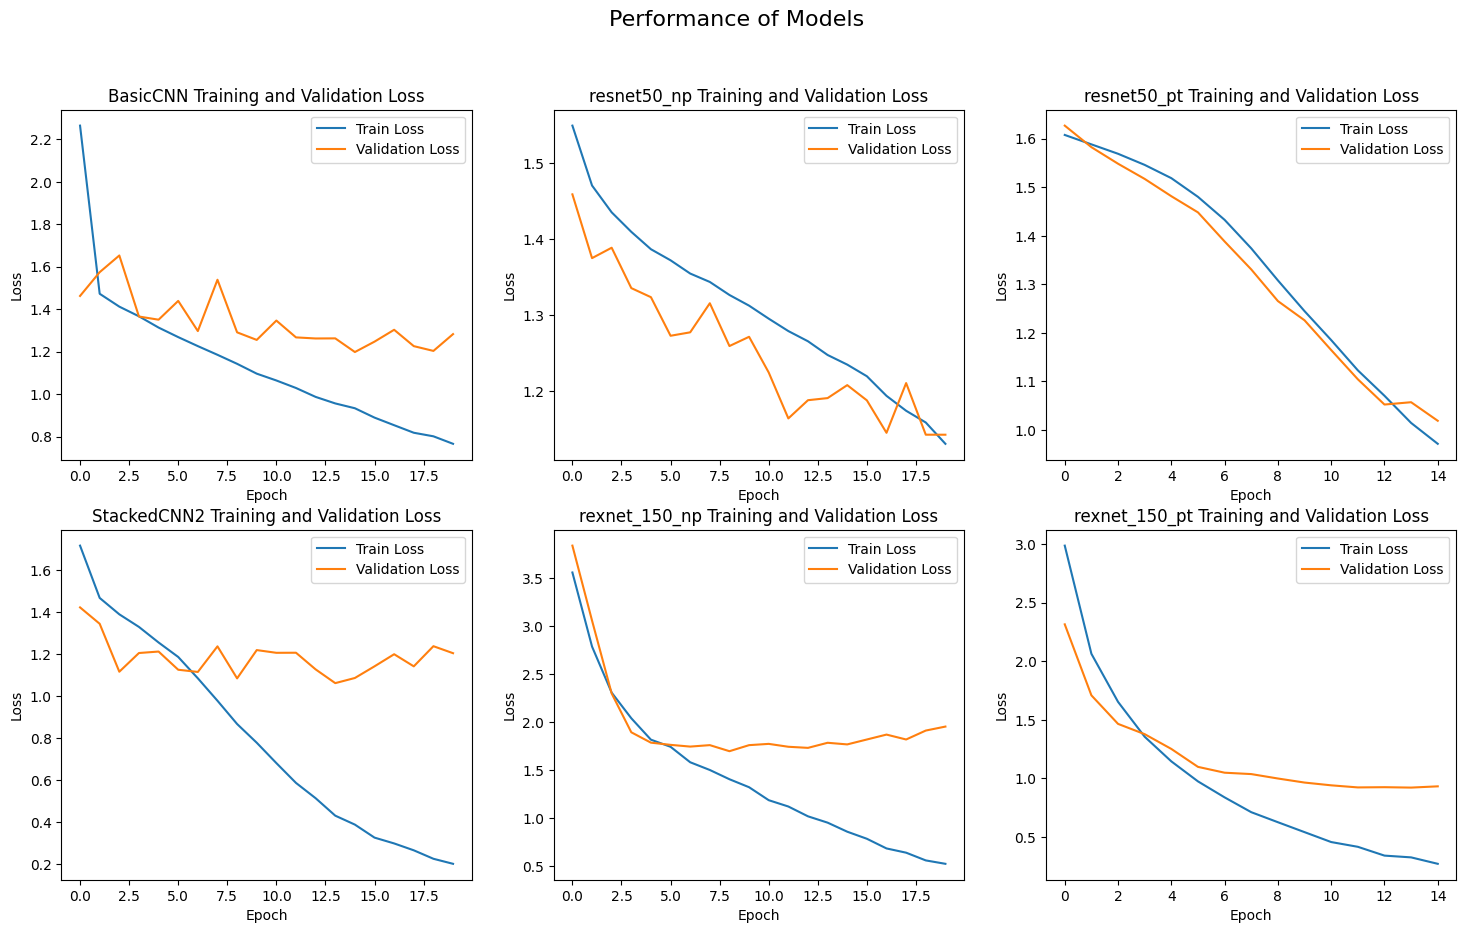

In [61]:

# Create a 2x3 grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Performance of Models', fontsize=16)

# Plot training and validation loss curves
for i, (train_loss, val_loss) in enumerate(zip(train_losses, val_losses)):
    ax = axes[i % 2, i // 2]  # Corrected subplot index calculation
    ax.plot(train_loss, label='Train Loss')
    ax.plot(val_loss, label='Validation Loss')
    ax.set_title(f'{model_list[i]} Training and Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()


# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show or save the visualization
plt.show()  # To display the plot

In [57]:
train_losses[0]==train_losses[2]

True

/tmp/ipykernel_135838/3740502874.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_list, rotation=45, ha='right')
/tmp/ipykernel_135838/3740502874.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_list, rotation=45, ha='right')
/tmp/ipykernel_135838/3740502874.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_list, rotation=45, ha='right')
/tmp/ipykernel_135838/3740502874.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(model_list, rotation=45, ha='right')


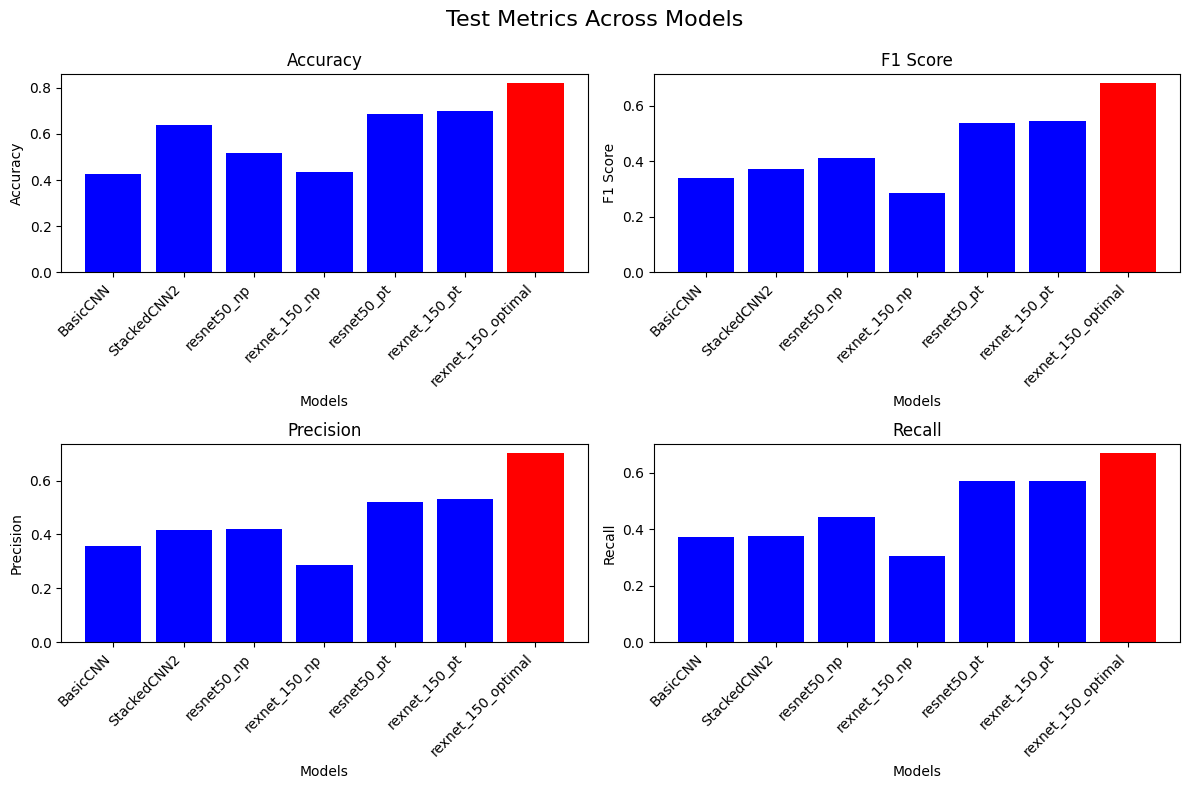

In [93]:
metrics_names = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Test Metrics Across Models', fontsize=16)

# Define colors for bars
num_models = len(model_list)
colors = ['b'] * (num_models - 1) + ['r']  # Blue for all models except the final one, which is red

# Plot test metrics for each metric
for i, metric_name in enumerate(metrics_names):
    ax = axes[i // 2, i % 2]  # Subplot index calculation
    ax.set_title(metric_name)

    metric_values = [model[i] for model in test_metrics]
    bars = ax.bar(model_list, metric_values, color=colors)

    ax.set_xlabel('Models')
    ax.set_ylabel(metric_name)

    # Rotate x-axis labels
    ax.set_xticklabels(model_list, rotation=45, ha='right')

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)

# Show the visualization
plt.show()


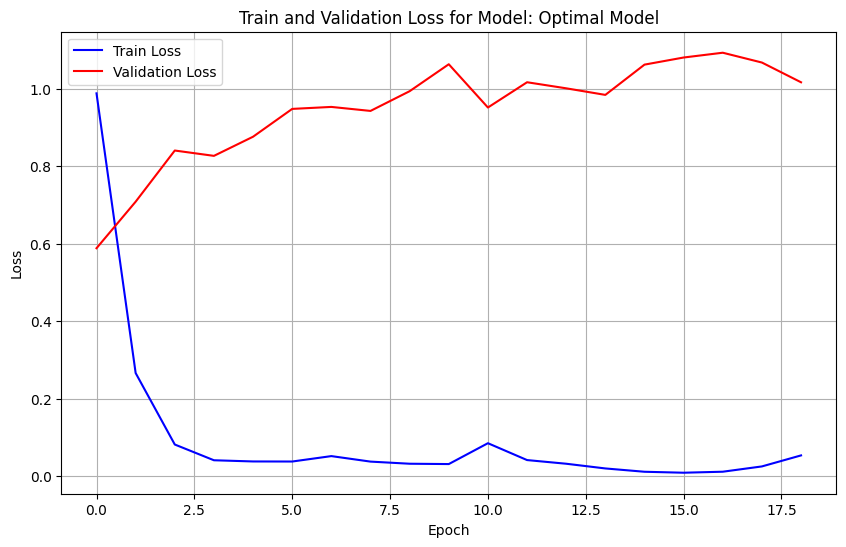

In [94]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses[-1], label='Train Loss', color='blue')
plt.plot(val_losses[-1], label='Validation Loss', color='red')
plt.title(f'Train and Validation Loss for Model: Optimal Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [97]:
from collections import defaultdict
class_counts_train = defaultdict(int)
for batch in train_dataloader:
    for label in batch[1]:
        class_counts_train[label.item()] += 1
        
class_counts_val = defaultdict(int)
for batch in val_dataloader:
    for label in batch[1]:
        class_counts_val[label.item()] += 1
        
class_counts_test = defaultdict(int)
for batch in test_dataloader:
    for label in batch[1]:
        class_counts_test[label.item()] += 1
        
for i in range(5):
    print(f'Train class {i} count: {class_counts_train[i]}')
    print(f'Val class {i} count: {class_counts_val[i]}')
    print(f'Test class {i} count: {class_counts_test[i]}')
    print('---')

item_totals_train = 0
item_totals_test = 0
item_totals_val = 0

for i in range(5):
    item_totals_train += class_counts_train[i]
    item_totals_test += class_counts_test[i]
    item_totals_val += class_counts_val[i]

for i in range(5):
    print(f'Train class {i} percentage: {(class_counts_train[i] / item_totals_train) * 100}')
    print(f'Val class {i} percentage: {(class_counts_val[i] / item_totals_val) * 100}')
    print(f'Test class {i} percentage: {(class_counts_test[i] / item_totals_test) * 100}')
    

Train class 0 count: 553
Val class 0 count: 184
Test class 0 count: 184
---
Train class 1 count: 1099
Val class 1 count: 366
Test class 1 count: 366
---
Train class 2 count: 1195
Val class 2 count: 399
Test class 2 count: 399
---
Train class 3 count: 6615
Val class 3 count: 2206
Test class 3 count: 2206
---
Train class 4 count: 1300
Val class 4 count: 433
Test class 4 count: 433
---
Train class 0 percentage: 5.138450102211485
Val class 0 percentage: 5.128205128205128
Test class 0 percentage: 5.128205128205128
Train class 1 percentage: 10.211856532243077
Val class 1 percentage: 10.200668896321071
Test class 1 percentage: 10.200668896321071
Train class 2 percentage: 11.103884036424457
Val class 2 percentage: 11.120401337792641
Test class 2 percentage: 11.120401337792641
Train class 3 percentage: 61.46627020999814
Val class 3 percentage: 61.482720178372354
Test class 3 percentage: 61.482720178372354
Train class 4 percentage: 12.07953911912284
Val class 4 percentage: 12.068004459308806
Tes